In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import Counter

import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Using TensorFlow backend.


In [2]:
# importing data
df = pd.read_hdf('../car.h5')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106494 entries, 0 to 160615
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 77.0+ MB


In [3]:
# settings changed so all data will be displayed
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
df.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False

In [4]:
# Target variable (car price) has two currencies
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [5]:
# normalizing target variable to one currency using function shown above

def normalize_price_value(x):
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5
    
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

Text(0.5, 1.0, 'price_value_PLN_log')

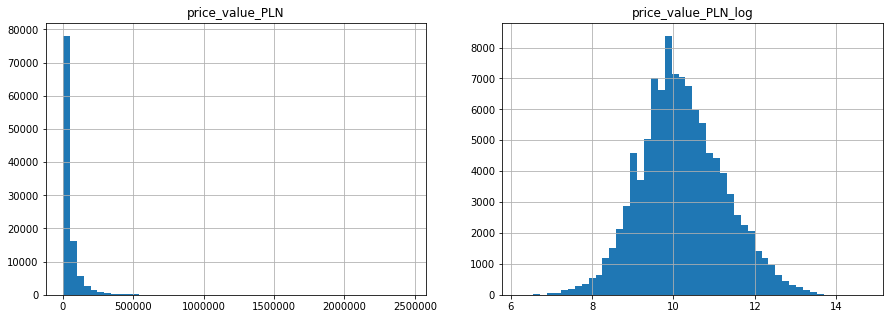

In [6]:
# It seems that sing logarithm of target variable is worth looking into

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['price_value_PLN'].hist(bins=50);
plt.title('price_value_PLN')
plt.subplot(1,2,2)
np.log1p(df['price_value_PLN']).hist(bins=50);
plt.title('price_value_PLN_log')

In [7]:
# logarithmic target variable is created
df['price_value_PLN_log'] = np.log1p(df['price_value_PLN'])

In [8]:
# all missing data is replaced with -1
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

5832640


0

In [9]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

In [10]:
def get_X_y_and_cros_val(model, feats, log=False): # cross validation with option to use logarithmic target variable
    
    X = df[ feats ].values
    y = df['price_value_PLN'].values if not log else df['price_value_PLN_log'].values
    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        
        
        y_pred = train_model.predict(X[test_idx])
        y_pred = np.expm1(y_pred) if log else y_pred
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    return scores, np.std(scores)

In [11]:
# Dummy model for reference
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

39702.02572163561

# feature engineering 

In [12]:
# all sets of features will be tested on the same model:
model = DecisionTreeRegressor(max_depth=5, random_state=0)

In [13]:
# first try: only bool features since it requiers no additional work
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

In [14]:
# original target variable
get_X_y_and_cros_val(model, feats, log=False)

([25076.606847115643, 24909.340696410825, 24992.17567774242],
 68.28715648360107)

In [15]:
#logarithmic target variable. Unfortunately score has worsen, will be double checked later.
get_X_y_and_cros_val(model, feats, log=True)

([37271.07676178811, 37203.219877094125, 37630.83489943696],
 187.64182243430503)

In [16]:
df.select_dtypes([np.object]).sample(10)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
80145,"[Osobowe, Renault, Megane, Renault Megane II (...","15:05, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji","Pleszew, pleszewski, Wielkopolskie",-1,Osoba prywatna,5,-1,Renault,-1,-1,4,-1,-1,30 kwiecień 2004,-1,200 000 km,-1,2004,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,-1,-1,Kompakt,Tak,-1,-1,-1,-1,-1,-1,-1,Osoby prywatnej,120 KM,-1,Wielka Brytania,-1,-1,-1,Diesel,-1,-1,-1,-1,-1,-1,-1,Megane,1 870 cm3,Tak,-1,-1,-1,-1,-1,-1,-1,-1,Fioletowy,-1,-1,Używane,II (2002-2008),-1,-1,-1,-1,-1,-1
101832,"[Osobowe, Škoda, Octavia, Škoda Octavia II (20...","21:47, 2 marca 2018",PLN,"Cena Brutto, Faktura VAT","Bydgoszcz, Kujawsko-pomorskie",-1,Osoba prywatna,5,-1,Škoda,-1,-1,5,-1,-1,28 grudzień 2009,-1,172 500 km,Tak,2009,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Kombi,Tak,-1,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,105 KM,-1,Polska,-1,-1,-1,Diesel,-1,-1,-1,-1,-1,-1,-1,Octavia,1 900 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,II (2004-2013),-1,-1,-1,-1,-1,-1
23282,"[Osobowe, Lexus, IS, Lexus IS I (1999-2005)]","09:40, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji","Wieliczka, wielicki, Małopolskie",-1,Osoba prywatna,5,-1,Lexus,-1,-1,5,-1,-1,-1,-1,246 000 km,-1,1999,JTDBS182200024606,-1,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,-1,-1,-1,Na tylne koła,-1,Sedan,Tak,-1,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,155 KM,-1,Austria,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,IS,1 998 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Bordowy,-1,-1,Używane,I (1999-2005),-1,-1,-1,Tak,-1,-1
9533,"[Osobowe, Ford, Fiesta, Ford Fiesta Mk7 (2008-)]","13:30, 4 marca 2018",PLN,"Cena Brutto, Faktura VAT","ul. Orkana 1 - 26-600 Radom, Mazowieckie (Polska)",Rad Motors Autoryzowany Dealer Forda,Dealer,-1,-1,Ford,-1,-1,5,-1,-1,styczeń 2016,-1,111 984 km,Tak,2015,WF0DXXGAKDFP00268,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,-1,-1,Kompakt,-1,Tak,Manualna,-1,-1,-1,-1,Tak,Firmy,75 KM,-1,Polska,-1,-1,Tak,Diesel,-1,-1,-1,-1,-1,-1,-1,Fiesta,1 498 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Inny kolor,-1,-1,Używane,Mk7 (2008-),-1,-1,-1,-1,-1,-1
21595,"[Osobowe, Toyota, Yaris, Toyota Yaris III (201...","16:06, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji","Ul.Rzemieślnicza,obok Restauracji Kuchnia Domo...",AUTO HANDEL RUBIKON AUTA Z PISEMNĄ GWARANCJĄ,Dealer,5,-1,Toyota,-1,-1,5,-1,-1,-1,-1,28 000 km,-1,2014,-1,Tak,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Auta miejskie,Tak,Tak,Manualna,-1,-1,-1,-1,-1,Firmy,69 KM,-1,Niemcy,-1,-1,-1,B

In [17]:
# features worth merging (chosen after feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year',
           'param_rodzaj-paliwa': 'param_fuel-type',
           'param_moc': 'param_engine-power',
           'param_marka-pojazdu': 'param_make',
           'param_napęd': 'param_transmission',
           'param_skrzynia-biegów': 'param_gearbox'
          }

# numerical features
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date features
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja', 'param_first-registration']

# blacklist features will not be used
black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency', 'price_value', 'price_value_PLN', 'price_value_PLN_log']

###### Mearging columns

In [18]:
# Function used to find columns carrying the same information (used on columns picked after feature importance check)
val_to_check = 'Manualna'
for column in df.columns:
    occurrences = (df[column] == val_to_check).sum()
    if occurrences > 0:
        print('occurrences of {} in {}: {}'.format(val_to_check, column, occurrences))

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


occurrences of Manualna in param_gearbox: 53
occurrences of Manualna in param_skrzynia-biegów: 73420


In [19]:
df['param_skrzynia-biegów'].unique()

array(['Manualna', 'Automatyczna hydrauliczna (klasyczna)',
       'Automatyczna dwusprzęgłowa (DCT, DSG)', -1,
       'Automatyczna bezstopniowa (CVT)',
       'Półautomatyczna (ASG, Tiptronic)'], dtype=object)

In [20]:
def check_if_complementing(feat1, feat2): # count of instances when data only in one of the columns
    has_data = {feat1: 0 , feat2: 0, 'both': 0}
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data['both'] += 1         
        elif df[feat1].iloc[i] != -1:
            has_data[feat1] += 1  
        elif df[feat2].iloc[i] != -1:
            has_data[feat2] += 1  
    print(has_data)

In [21]:
# before merging columns were checked if they contain data that is complementary or just duplicates
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)
    print()

{'param_liczba-drzwi': 96594, 'param_door-count': 74, 'both': 0}

{'param_przebieg': 106057, 'param_mileage': 82, 'both': 0}

{'param_pojemność-skokowa': 101389, 'param_engine-capacity': 79, 'both': 0}

{'param_emisja-co2': 2086, 'param_co2-emissions': 3, 'both': 0}

{'param_rok-produkcji': 106302, 'param_year': 83, 'both': 0}

{'param_rodzaj-paliwa': 106302, 'param_fuel-type': 83, 'both': 0}

{'param_moc': 97009, 'param_engine-power': 75, 'both': 0}

{'param_marka-pojazdu': 106302, 'param_make': 83, 'both': 0}

{'param_napęd': 90084, 'param_transmission': 69, 'both': 0}

{'param_skrzynia-biegów': 100676, 'param_gearbox': 77, 'both': 0}



In [22]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]

In [29]:
# merge data in 'doubles' dictionary
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)
    
# delete no longer needed columns
to_delate = doubles.values()
for d in to_delate:
    del df[d]

###### Caterogical features

In [31]:
# picking categorical features form df
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]

# using factorize on categorical features
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

['seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'param_uszkodzony__cat',
 'param_marka-pojazdu__cat',
 'param_model__cat',
 'param_engine-code__cat',
 'param_country-of-origin__cat',
 'param_faktura-vat__cat',
 'param_vin__cat',
 'param_perłowy__cat',
 'param_homologacja-ciężarowa__cat',
 'param_service-record__cat',
 'param_metallic__cat',
 'param_leasing-concession__cat',
 'param_color__cat',
 'param_financing-option__cat',
 'param_original-owner__cat',
 'param_vat-marża__cat',
 'param_kategoria__cat',
 'param_leasing__cat',
 'param_zarejestrowany-jako-zabytek__cat',
 'param_napęd__cat',
 'param_typ__cat',
 'param_metalik__cat',
 'param_pierwszy-właściciel__cat',
 'param_skrzynia-biegów__cat',
 'param_vat-discount__cat',
 'param_no-accident__cat',
 'param_particle-filter__cat',
 'param_zarejestrowany-w-polsce__cat',
 'param_oferta-od__cat',
 'param_kraj-pochodzenia__cat',
 'param_serwisowany-w-aso__cat',
 'param_rodzaj-paliwa__cat',
 'param_możliwość-finansowania__

In [32]:
# model trained with bool and categorical features. Score improved.
feats = list(bool_feats) + list(cat_feats)
get_X_y_and_cros_val(model, feats)

([20197.073105073003, 20364.769520262143, 20327.6146409624], 71.91326976560819)

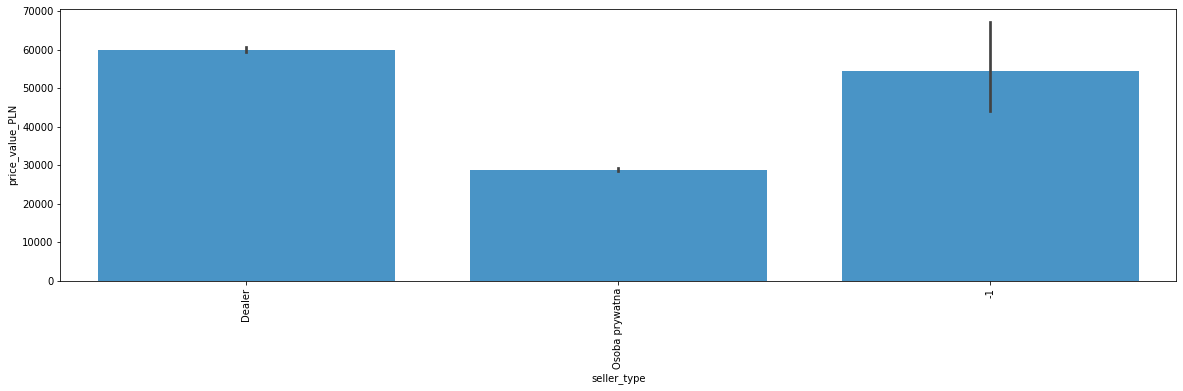

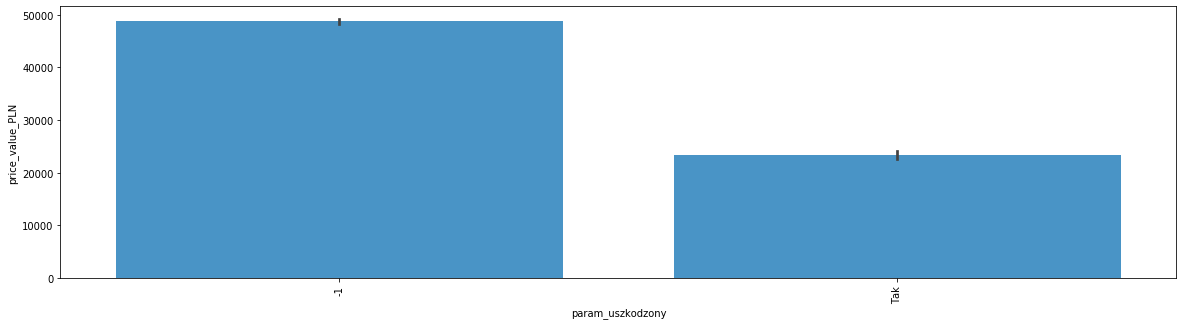

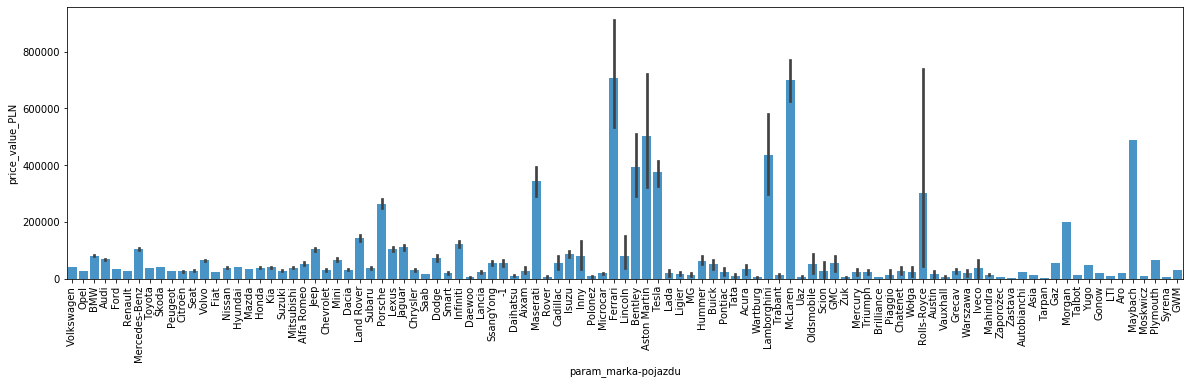

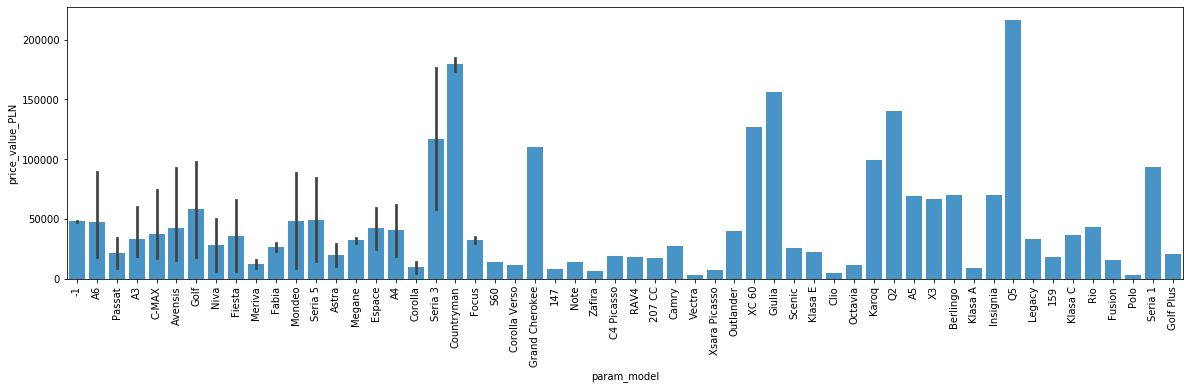

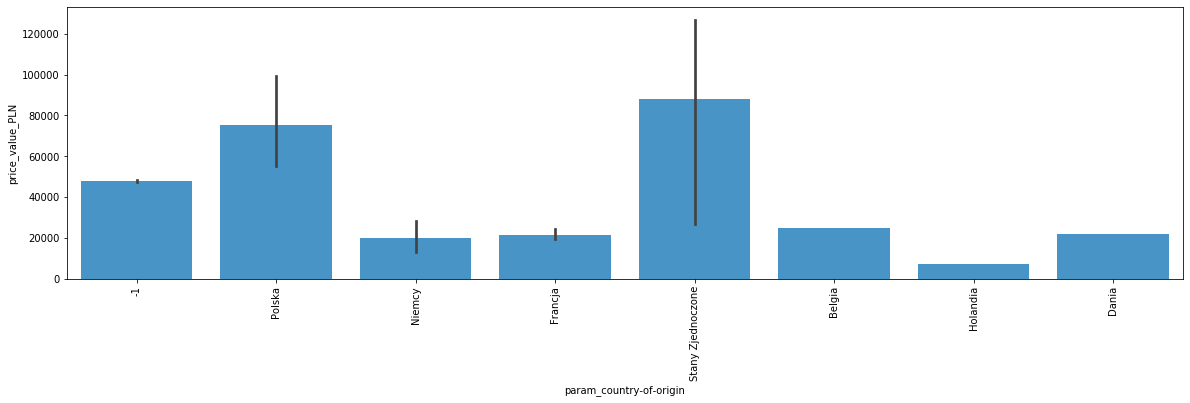

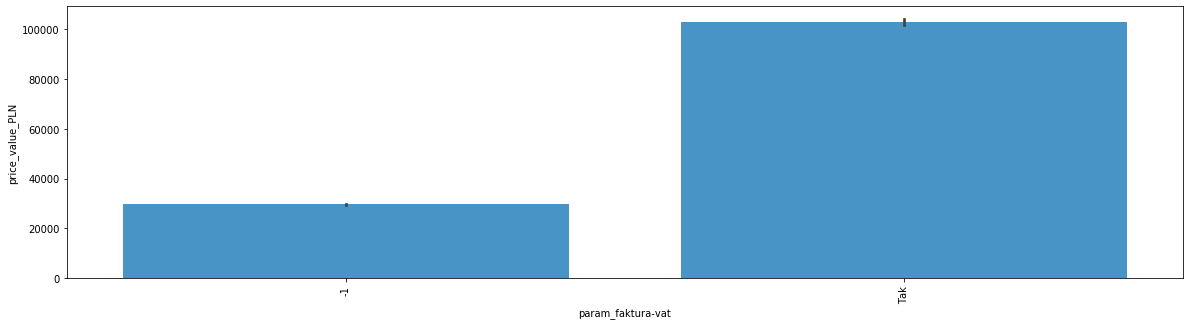

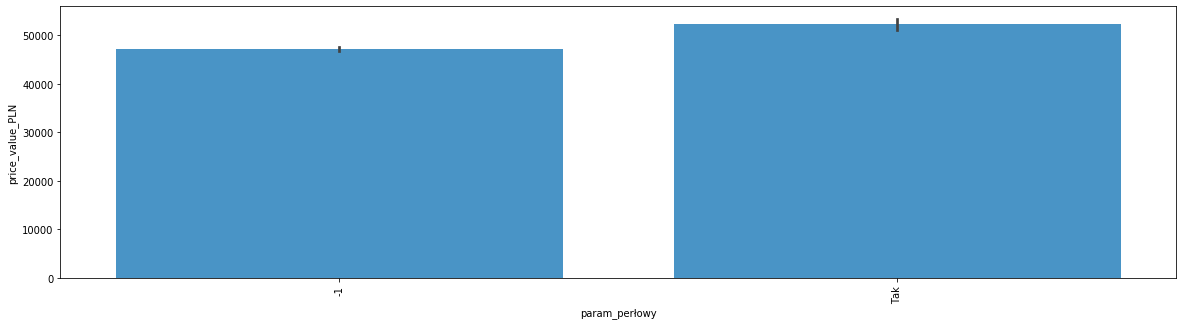

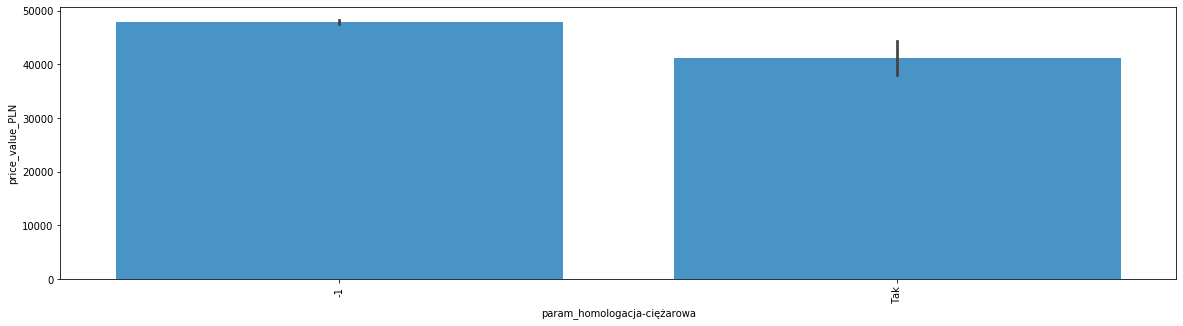

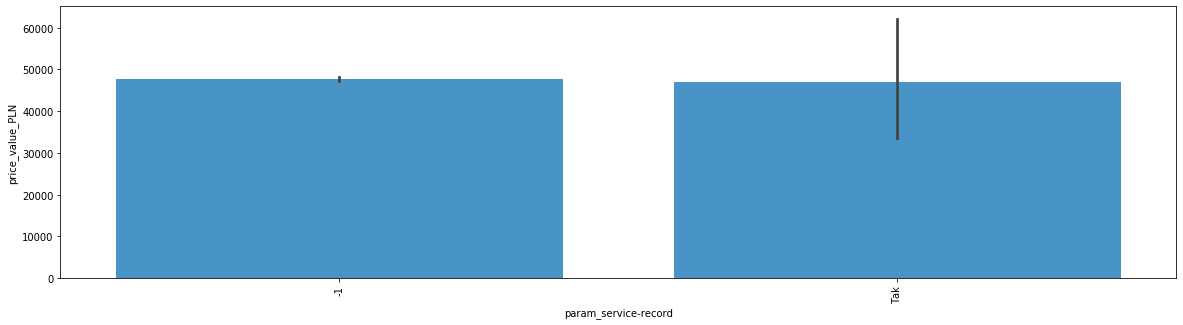

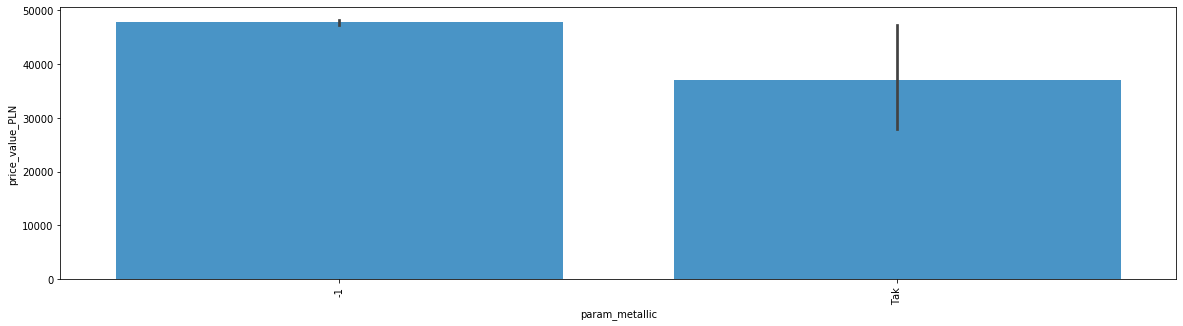

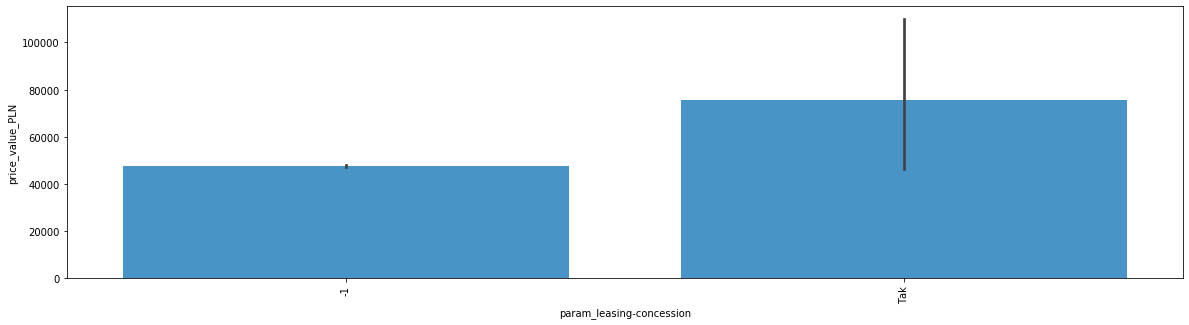

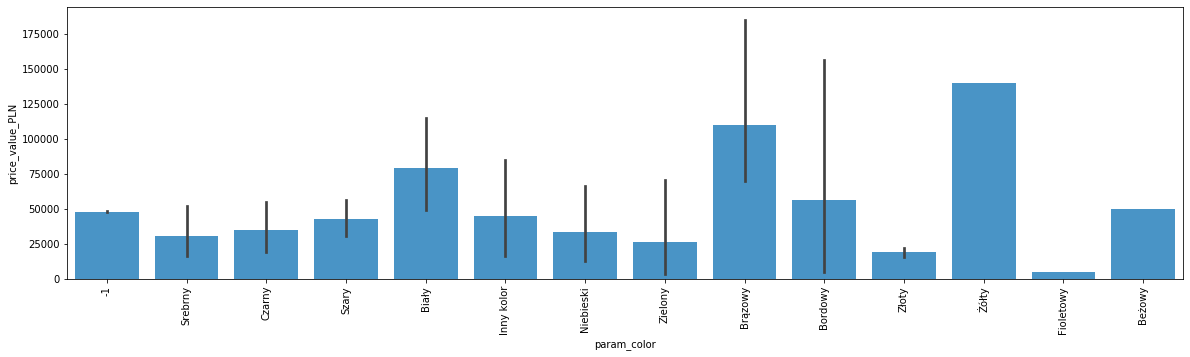

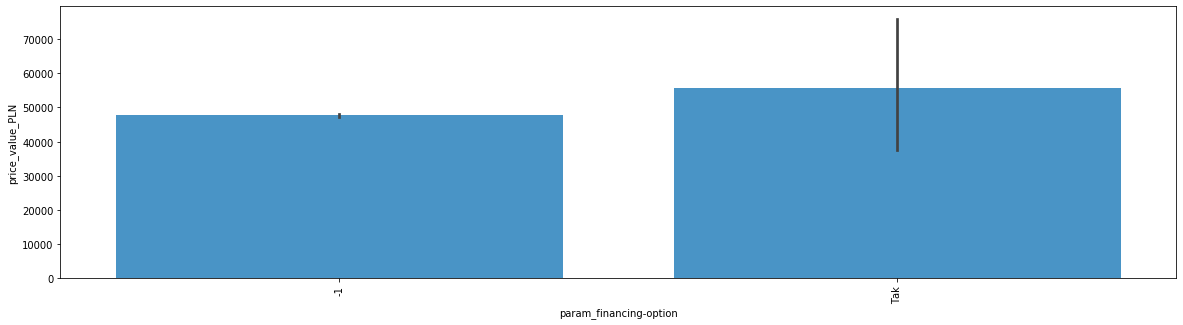

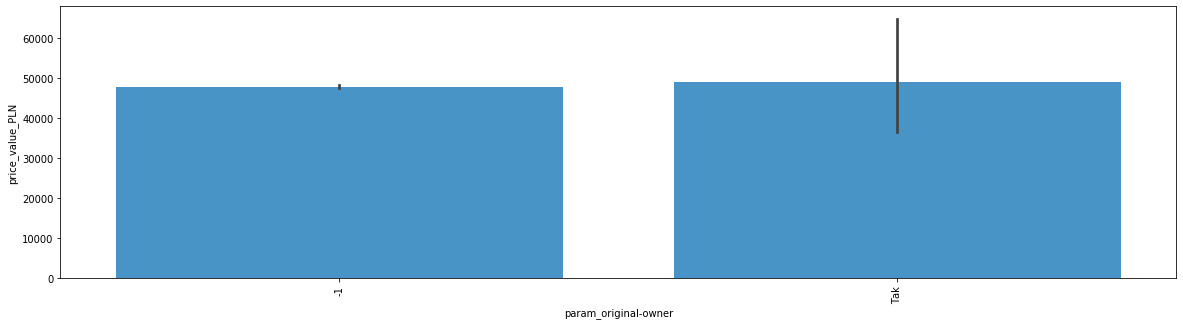

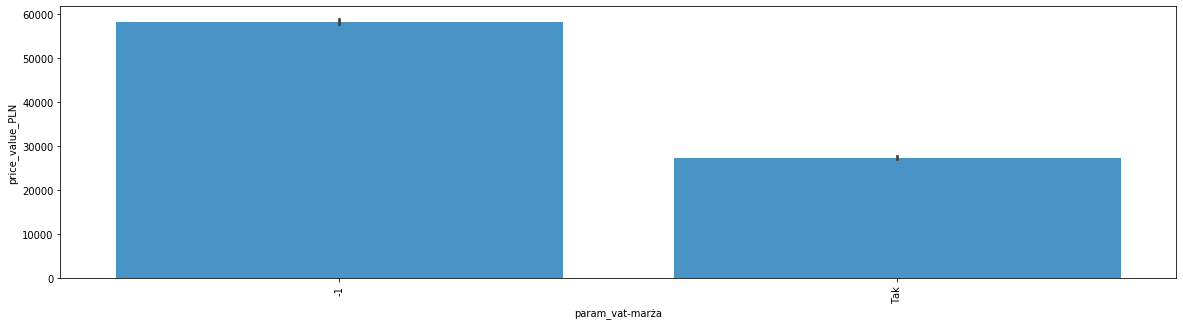

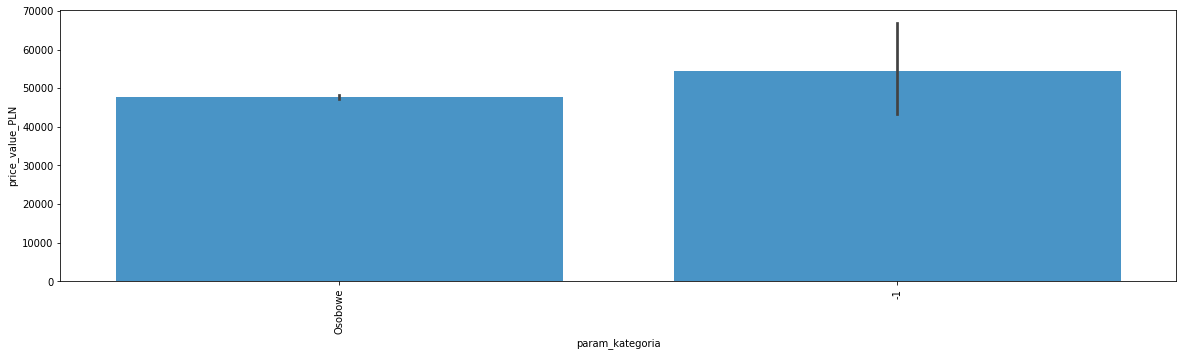

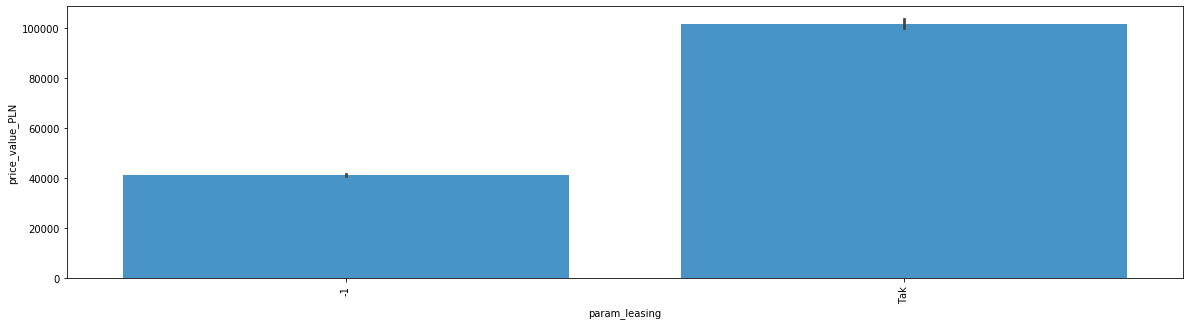

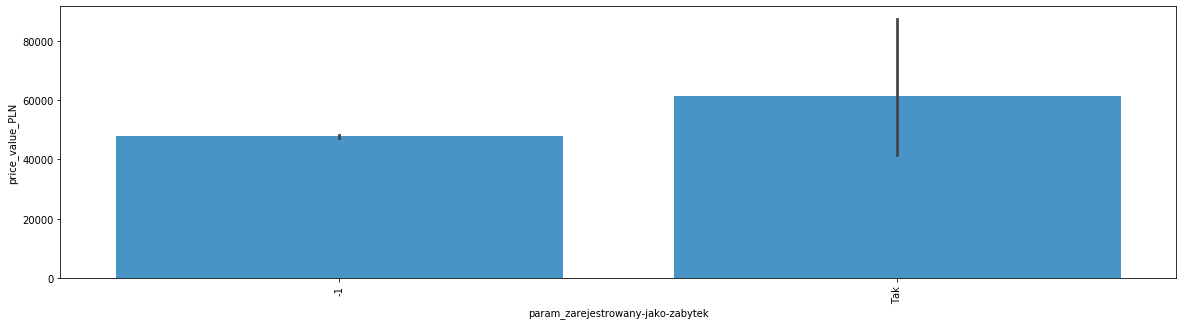

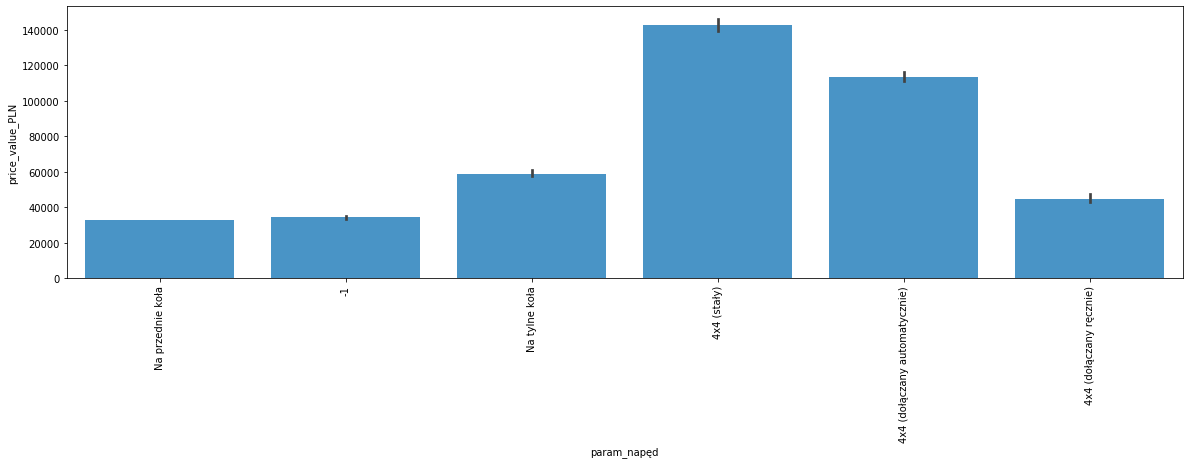

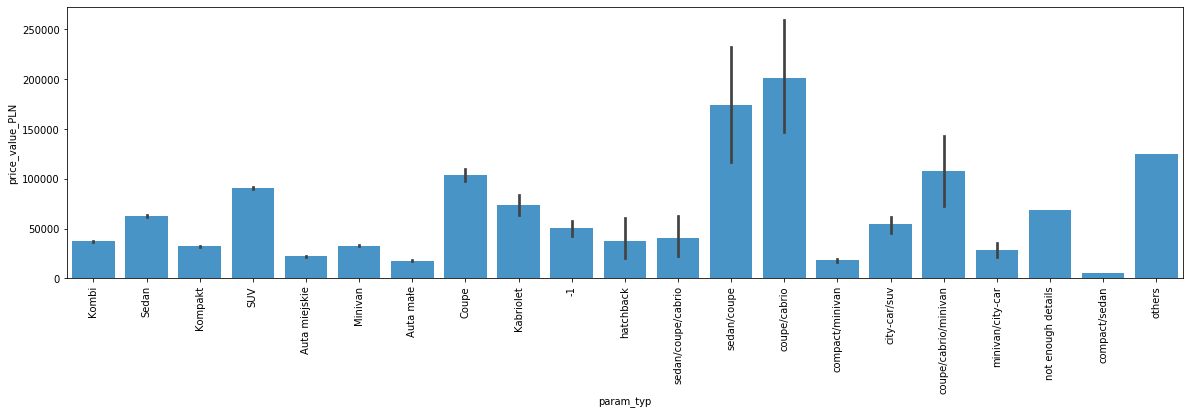

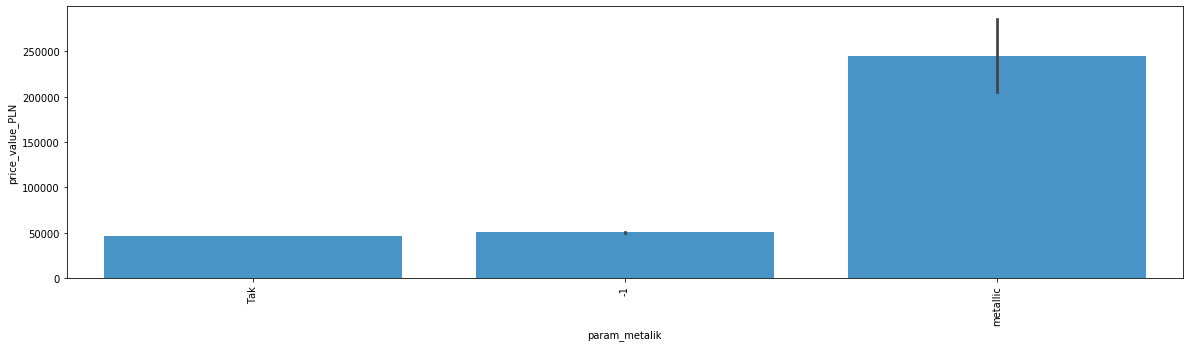

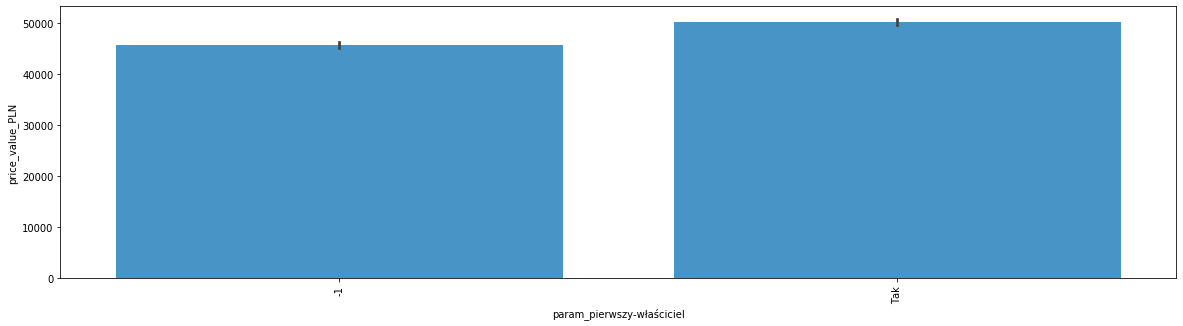

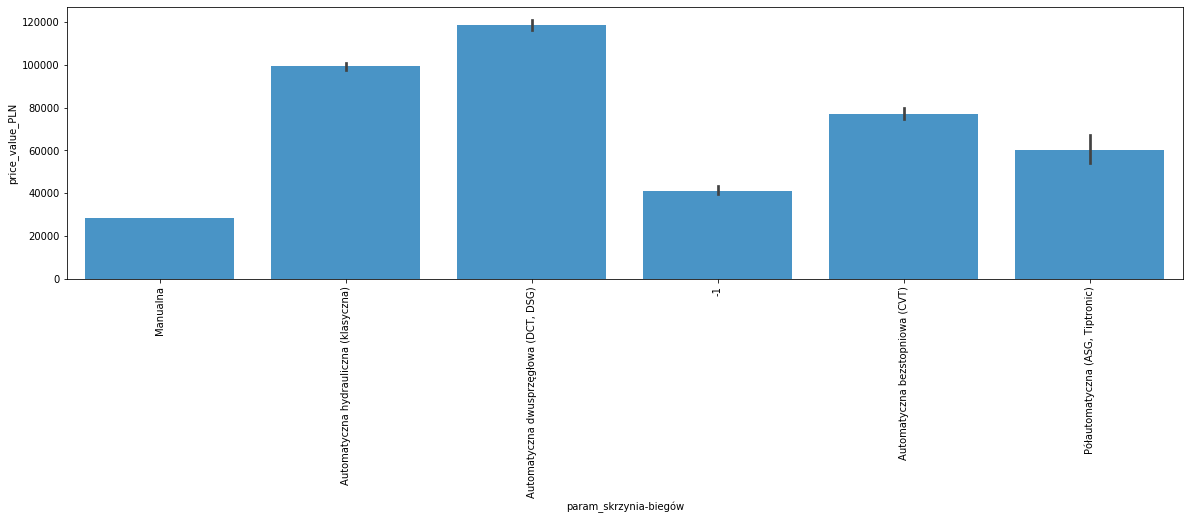

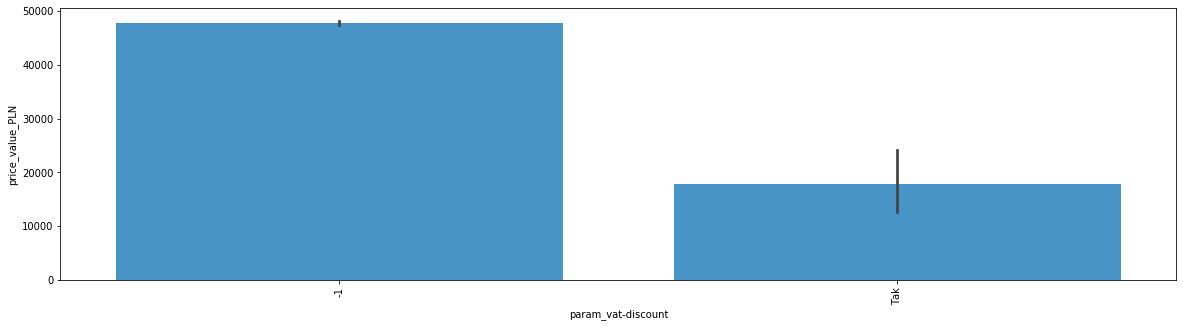

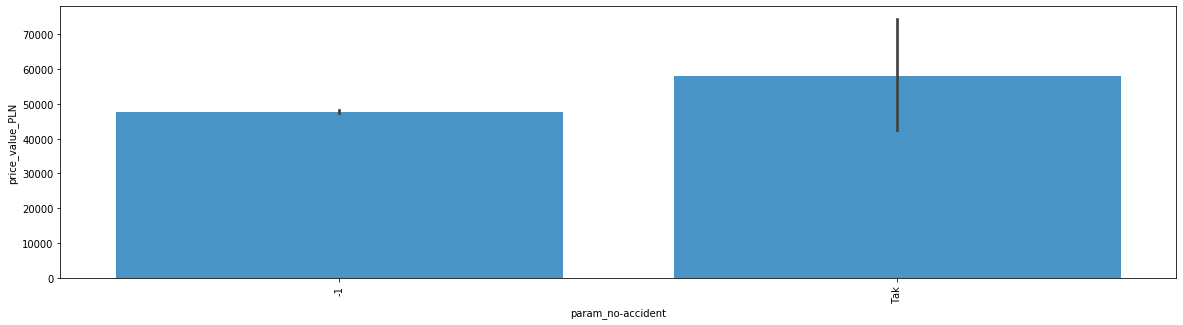

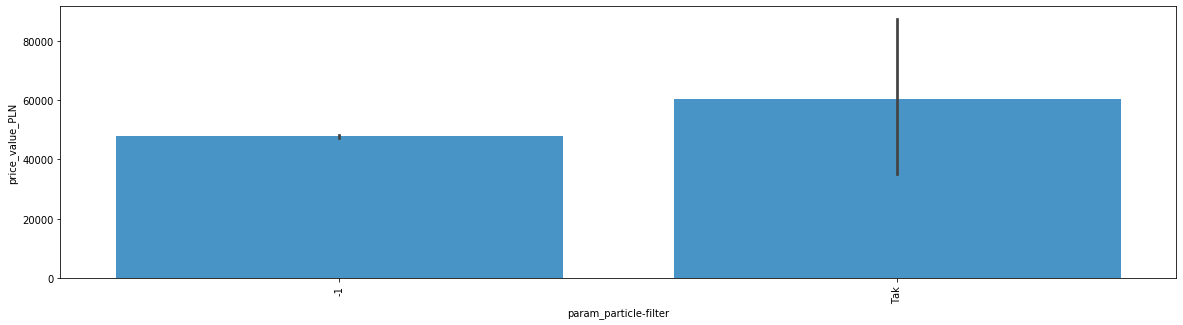

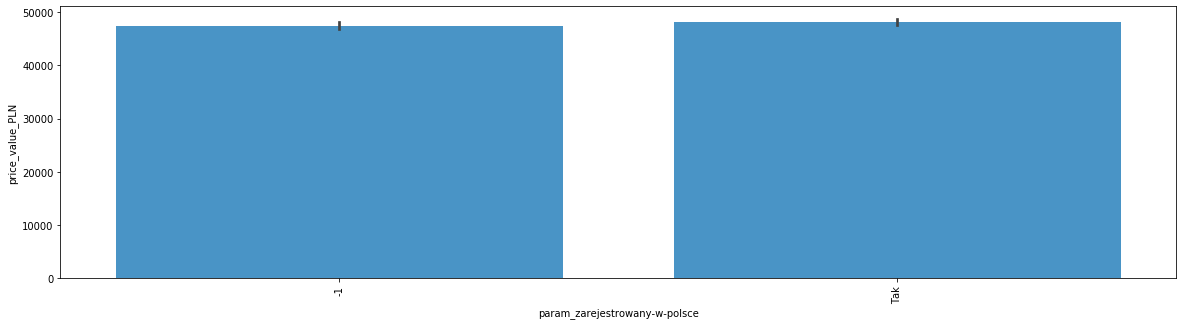

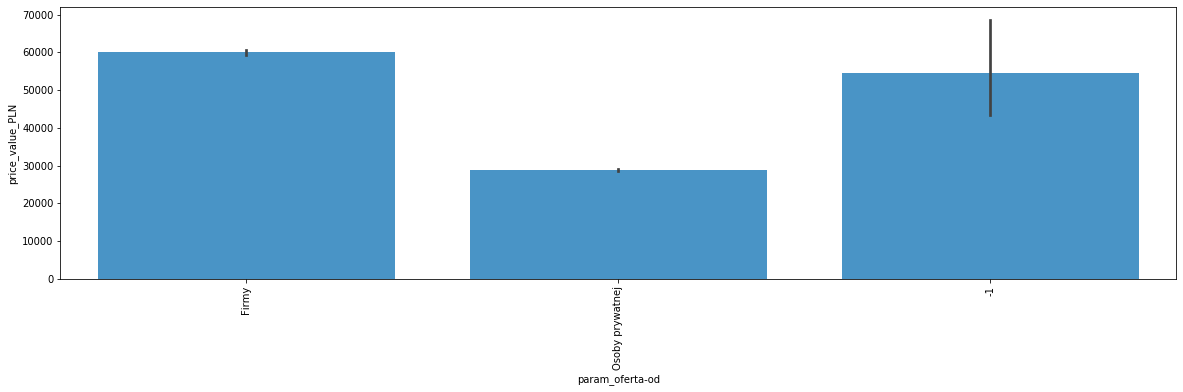

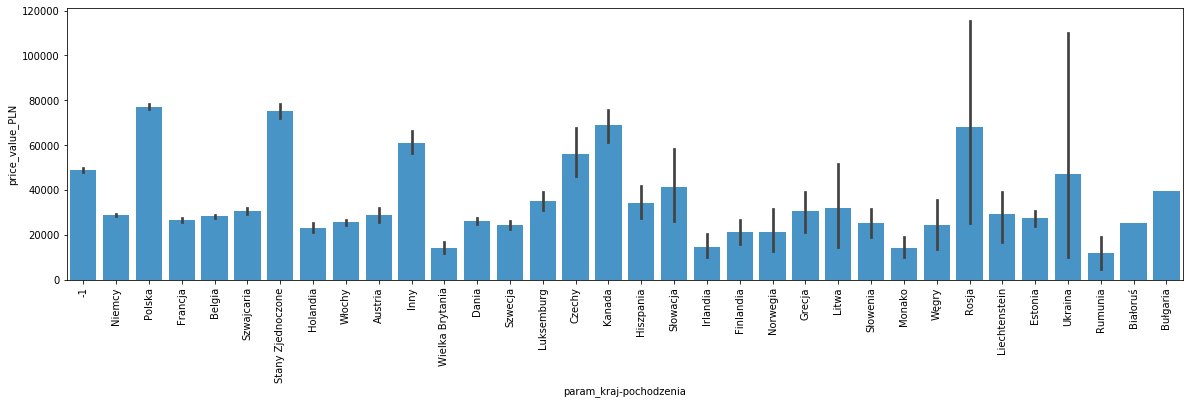

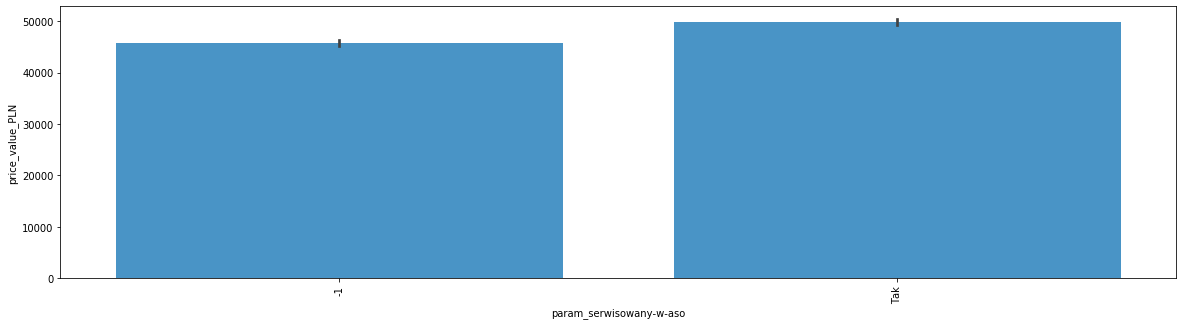

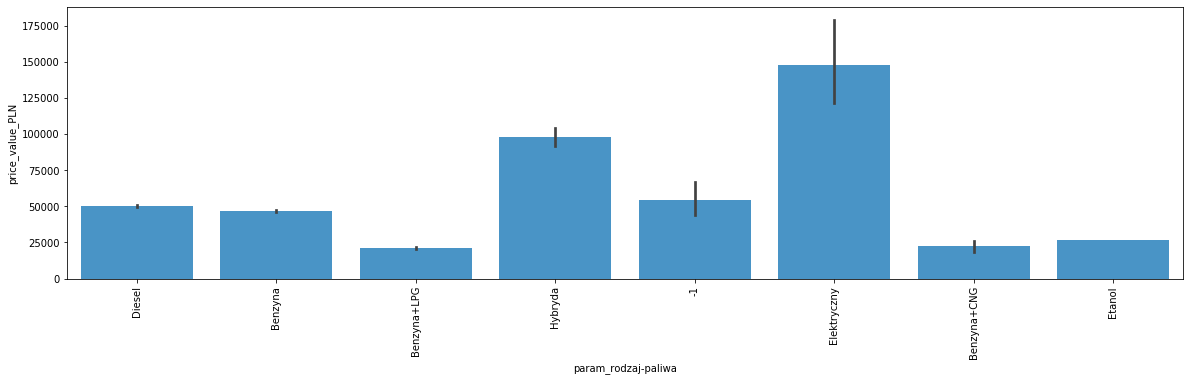

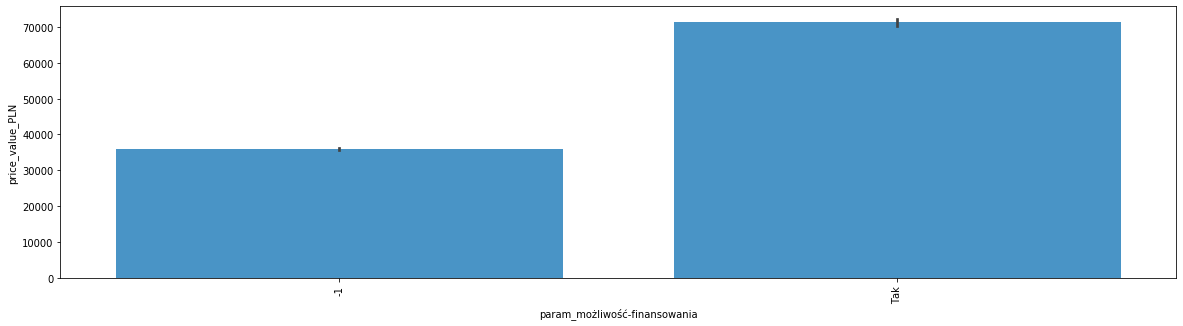

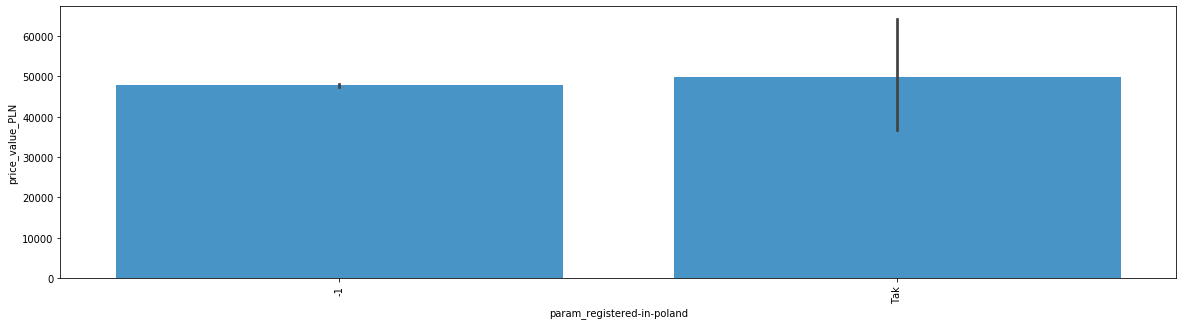

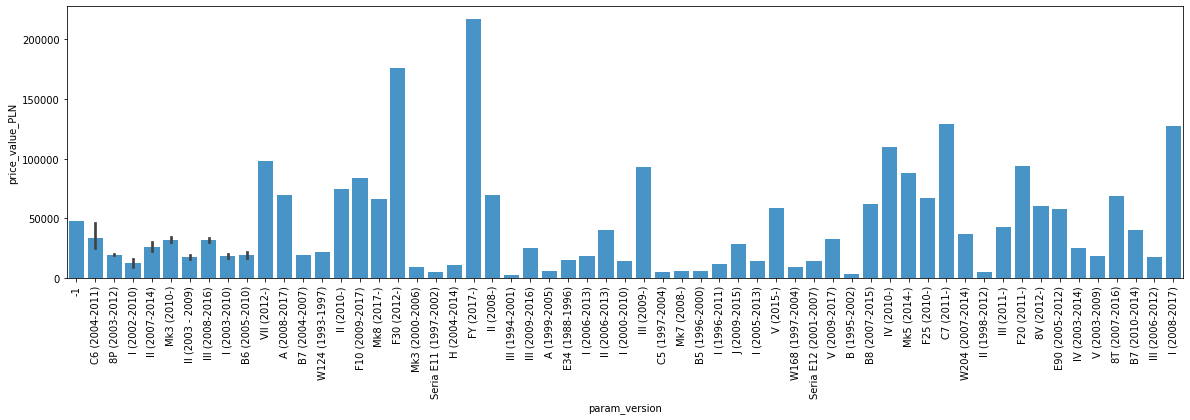

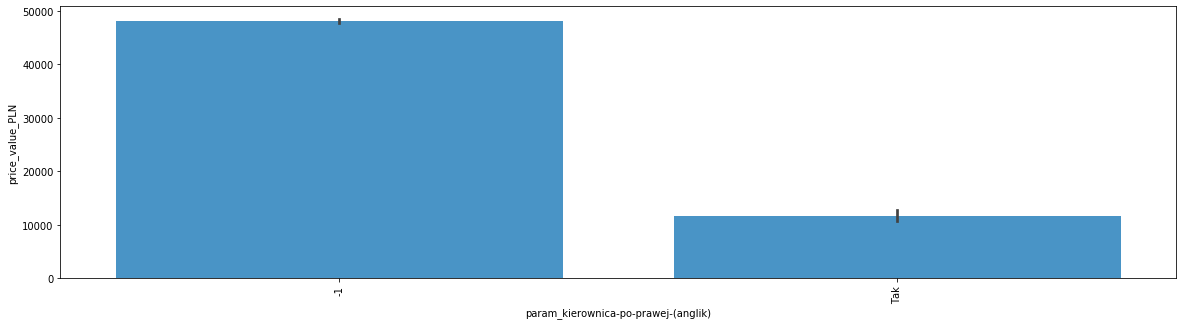

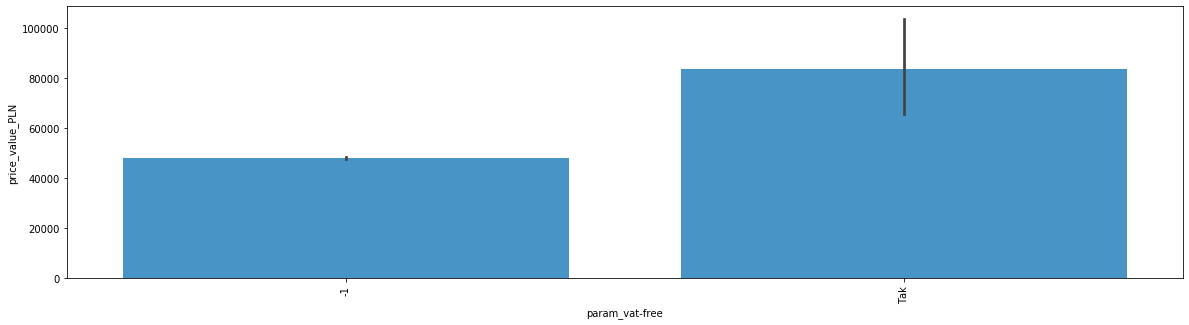

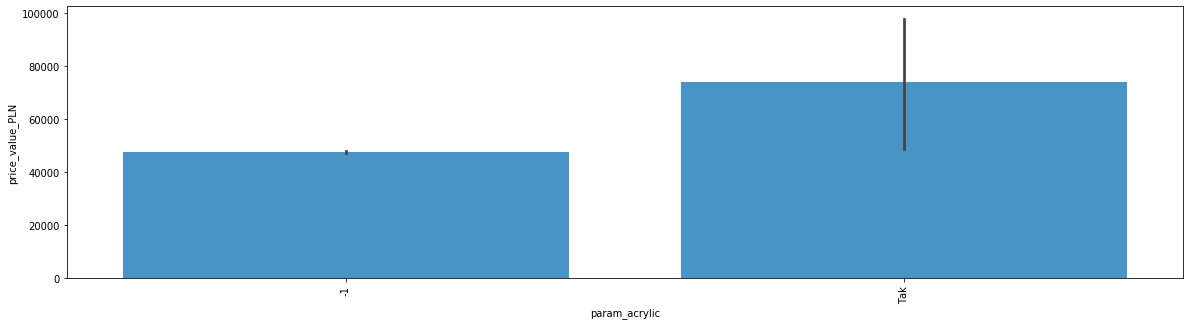

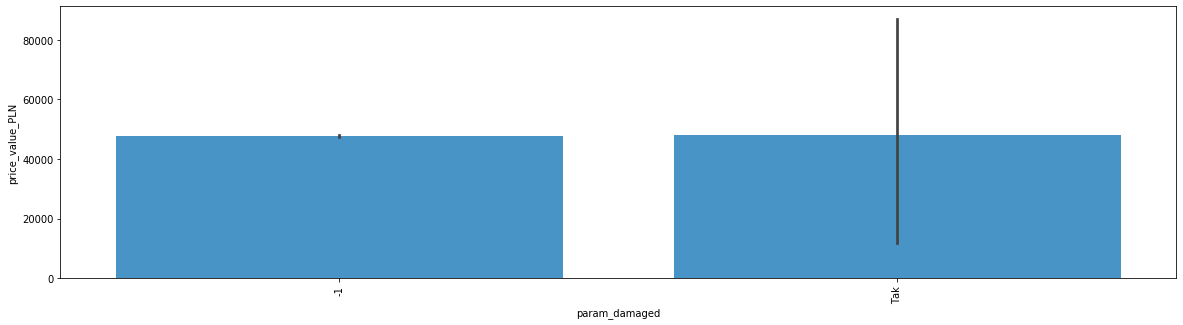

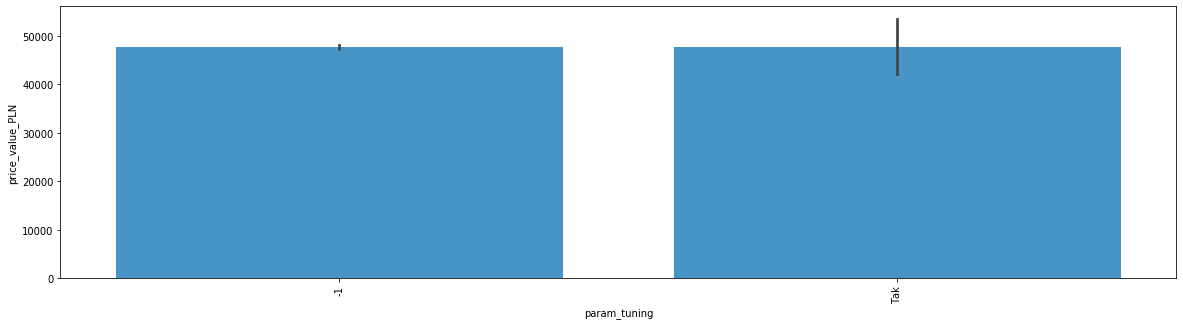

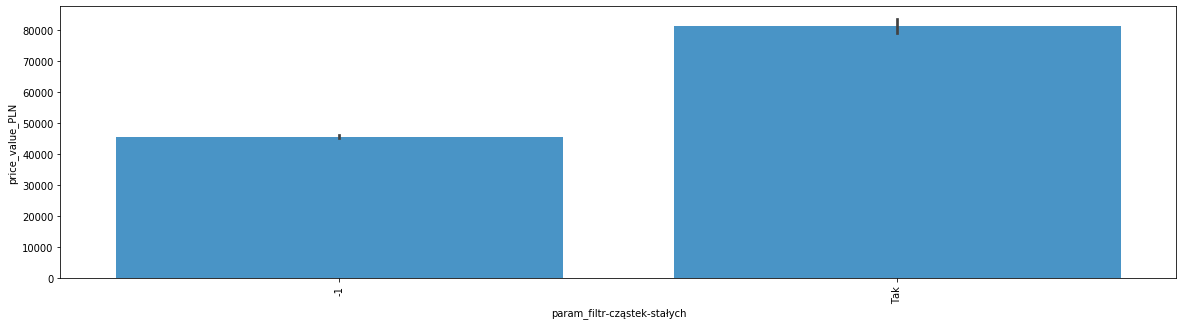

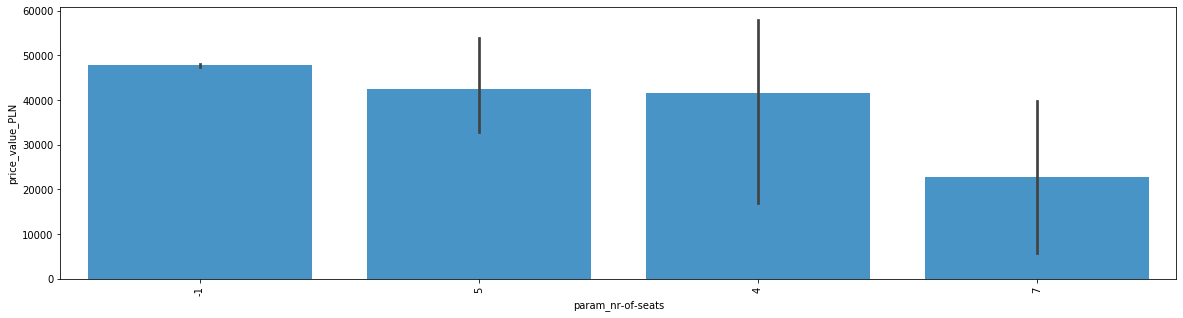

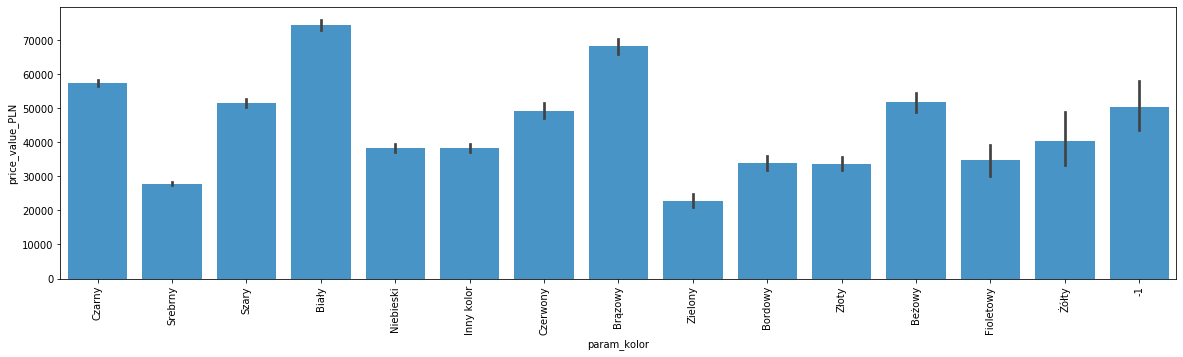

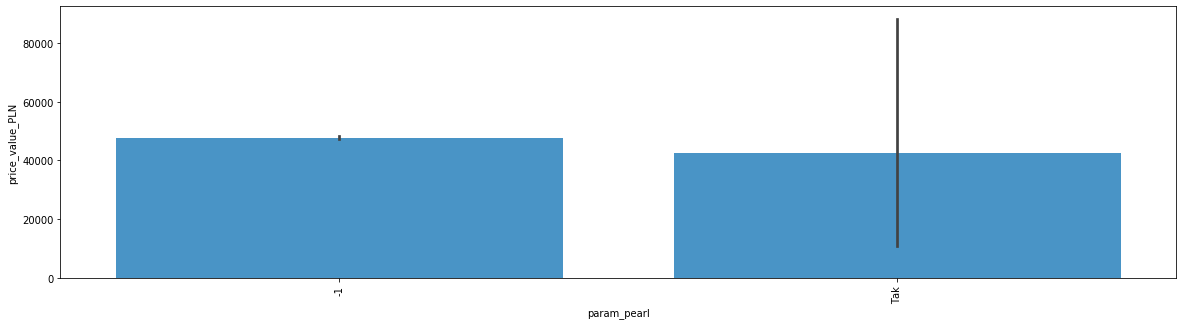

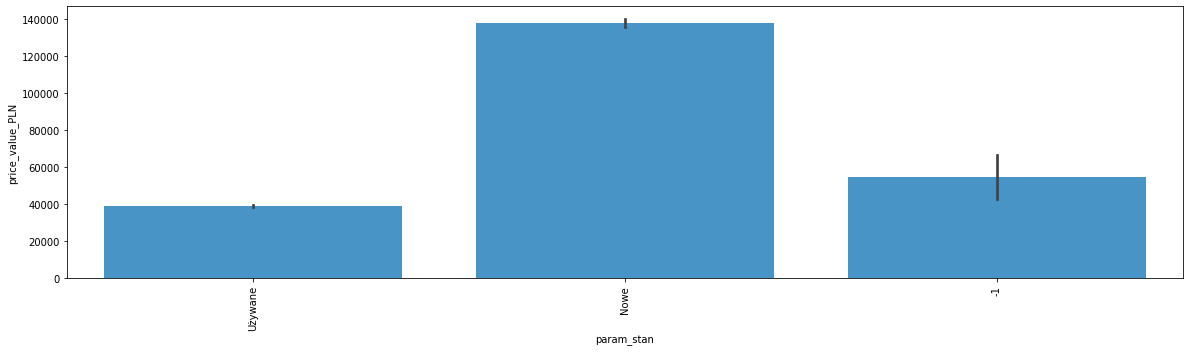

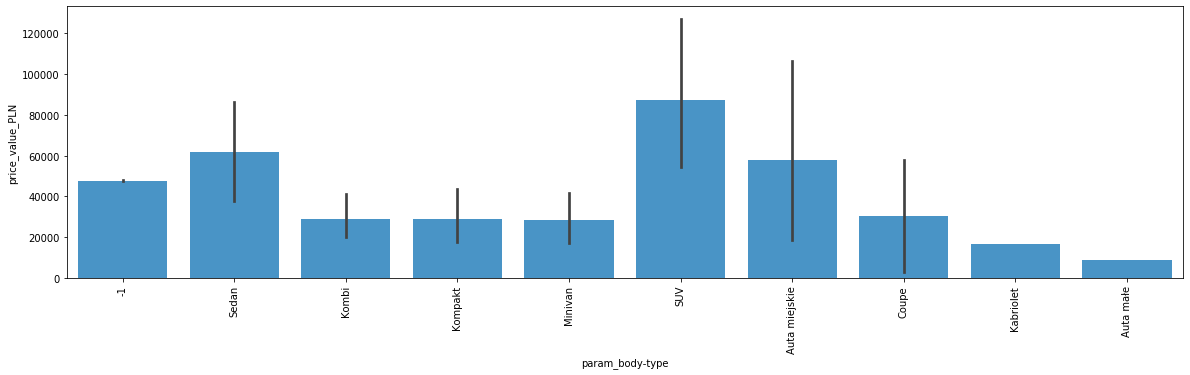

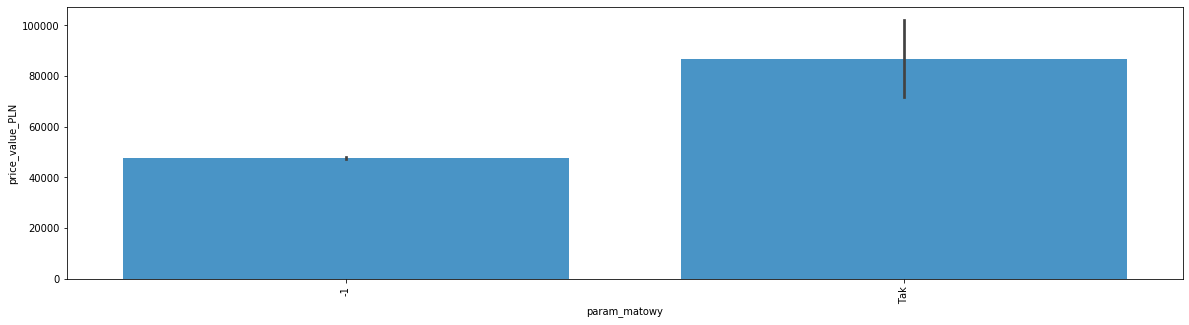

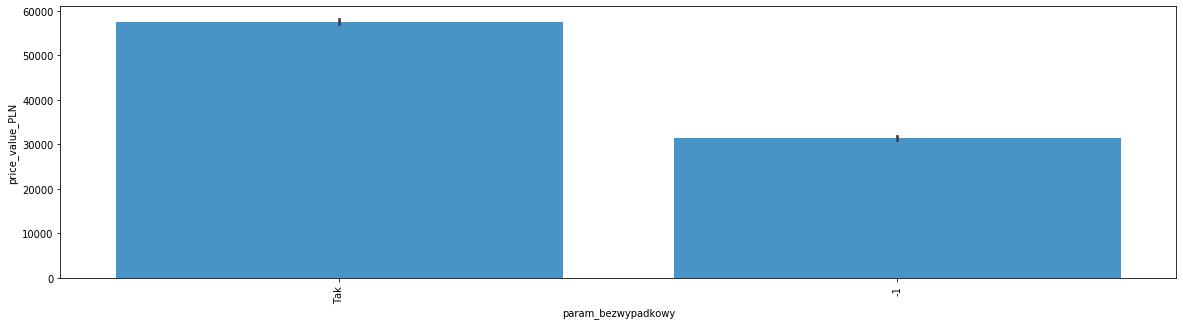

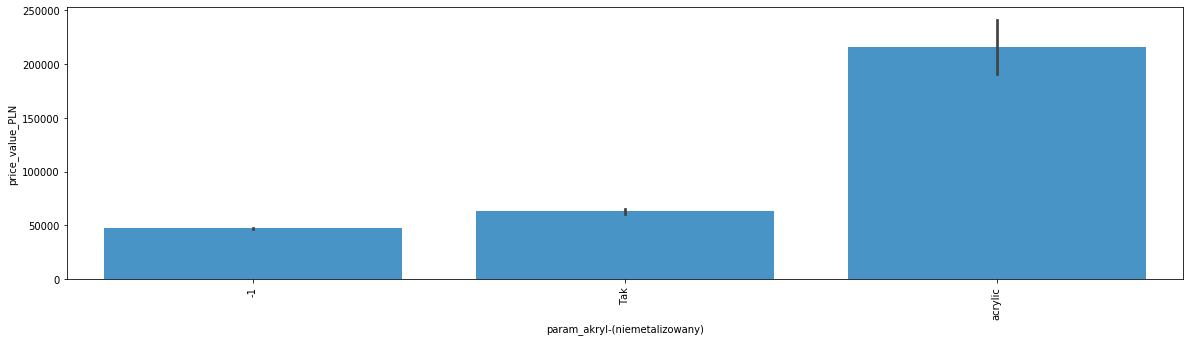

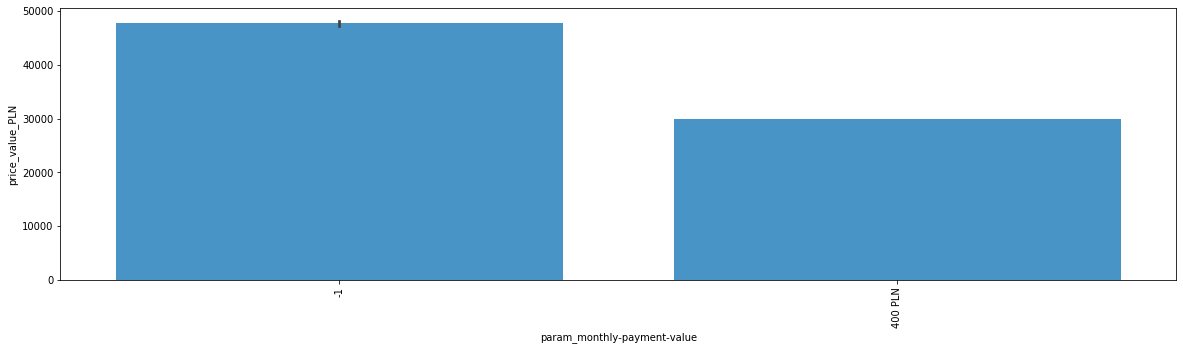

In [33]:
# plotting categorical features to look for potentially important ones
# categories are sorted by value_counts

cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat', 'param_wersja__cat', 'param_model-pojazdu__cat']

for cat_feat in cat_feats:
    if cat_feat not in cat_no_plot:
        cat_name = cat_feat[:-len(cat_feat_prefix)]
        plt.figure(figsize=(20,5))
        sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
        plt.xticks(rotation=90);
        plt.show()

###### numerical features

In [34]:
# numerical features picked from df
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [38]:
df['param_moc'].sample(5)

150549    126 KM
157088    150 KM
69546     110 KM
49444     126 KM
105713    153 KM
Name: param_moc, dtype: object

In [39]:
def get_rid_of_unit_and_dec(val): # getting rid of units, spaces between numbers and decimals
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val

In [40]:
# pulling numerical data from strings
num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)

num_feats = [x for x in df.columns if num_feat_prefix in x]

In [41]:
# model trained with bool, categorical and numerical features. Score significantly improved.
feats = list(bool_feats) + list(cat_feats) + list(num_feats)

get_X_y_and_cros_val(model, feats, log=False)

([14198.374124514623, 14763.79421947926, 14567.378956949546],
 234.38889941120422)

In [42]:
# Double checking with logarithmic target variable
get_X_y_and_cros_val(model, feats, log=True)

([43533.61941461498, 44240.73875922477, 43841.1282692485], 289.495347669099)

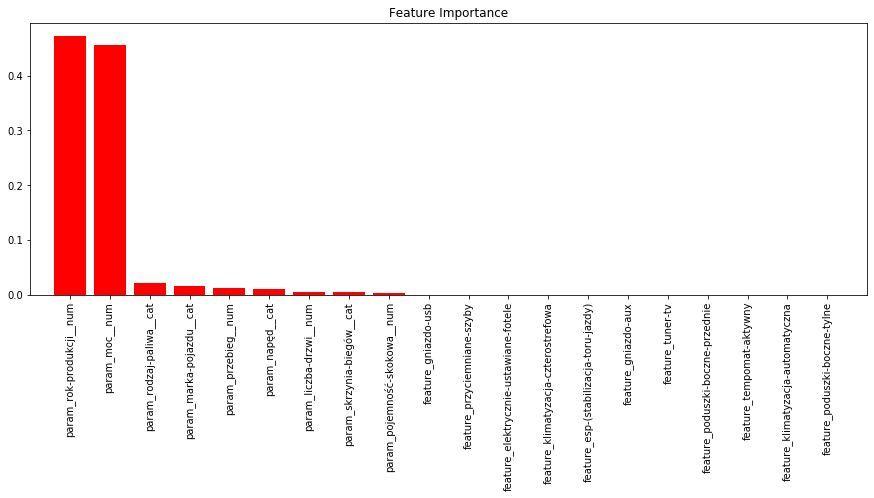

In [43]:
# after each iteration of feature engineering feature importance and permutation importance was checked
# to look for features worth working on in next iteration

X = df[ feats ]
y = df['price_value_PLN']
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

In [44]:
imp = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.7156 ± 0.0105,param_rok-produkcji__num
0.5769 ± 0.0086,param_moc__num
0.0374 ± 0.0048,param_rodzaj-paliwa__cat
0.0238 ± 0.0008,param_przebieg__num
0.0235 ± 0.0019,param_marka-pojazdu__cat
0.0219 ± 0.0007,param_napęd__cat
0.0088 ± 0.0004,param_skrzynia-biegów__cat
0.0074 ± 0.0031,param_liczba-drzwi__num
0.0048 ± 0.0001,param_pojemność-skokowa__num
0 ± 0.0000,feature_łopatki-zmiany-biegów


# Model selection and optimization

'Permutation importance' above sugest that only 9 features heave any impact on model training.

In [142]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
less_feats = ['param_rok-produkcji__num','param_moc__num','param_rodzaj-paliwa__cat','param_przebieg__num','param_marka-pojazdu__cat','param_napęd__cat','param_skrzynia-biegów__cat','param_liczba-drzwi__num','param_pojemność-skokowa__num']

In [75]:
# Since using logarithm of target vartiable did not bring results
# all models will be tested on the same set of features using standard 3 fold cross_val_score
def get_X_y(feats):
    return df[ feats ].values, df['price_value_PLN'].values

def test_model(model, feats):
    X, y = get_X_y(feats)
    
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return np.abs(np.mean(scores)), np.std(scores)

def plot_fi_lc_e5(model, feats, pi=True, lc=True, e5=False):
    X, y = get_X_y(feats)
    model.fit(X, y)
    
    if pi == True:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    if lc == True:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');
    if e5 == True:
        imp = PermutationImportance(model, random_state=0).fit(X,y)
        return eli5.show_weights(imp, feature_names=feats)

In [67]:
# Testing decision Tree
model = DecisionTreeRegressor(max_depth=10, random_state=0)
test_model(model, feats)

(10681.668394656088, 117.90373935492903)

In [68]:
# Testing decision Tree
model = DecisionTreeRegressor(max_depth=10, random_state=0)
test_model(model, less_feats)

(10876.154516893592, 55.372783128649544)

Scores obove show that score with more features is bettor so all will be used for now.

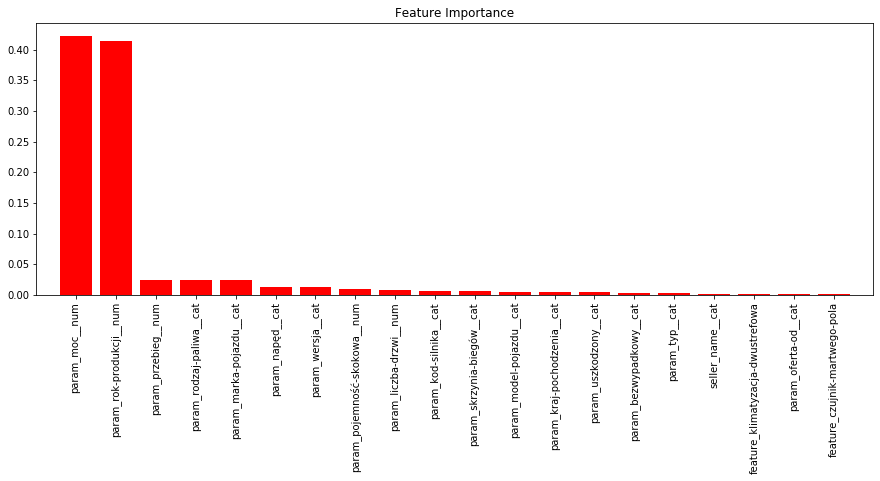

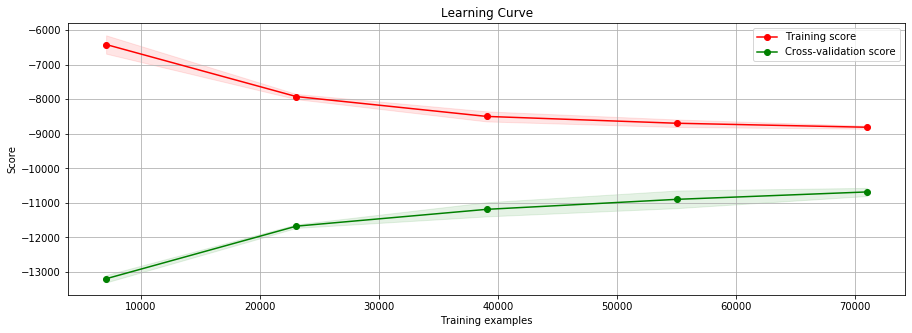

In [48]:
plot_fi_lc_e5(model, feats, True, True, False)

In [49]:
# Testing Random Forest
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
test_model(model, feats)

(9263.115157974702, 90.20634050382377)

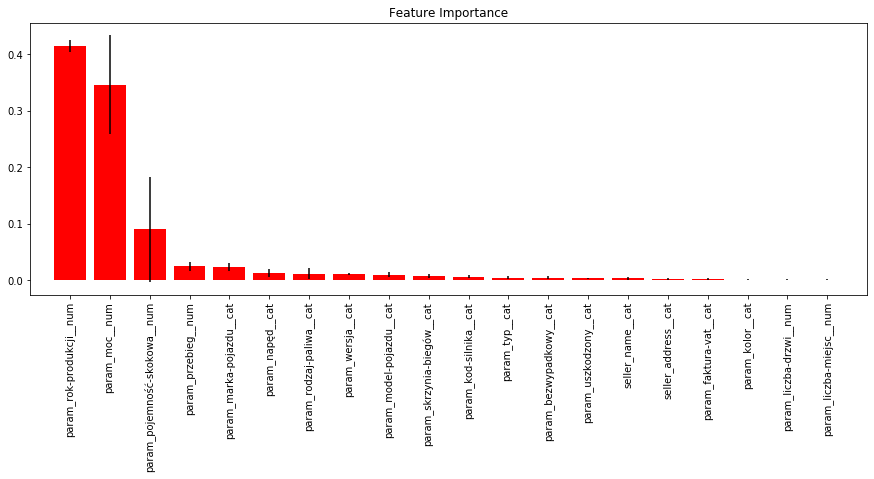

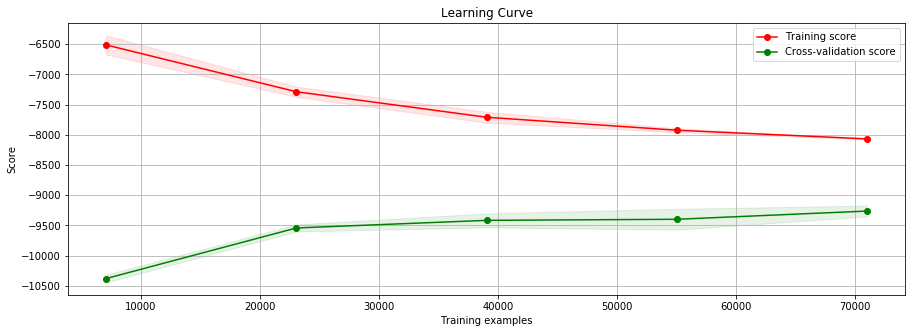

In [50]:
plot_fi_lc_e5(model, feats, True, True, False)

In [51]:
# testing XGB regressor
xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

model = xgb.XGBRegressor(**xgb_params)
test_model(model, feats)

(7191.896955026012, 55.36640022504221)

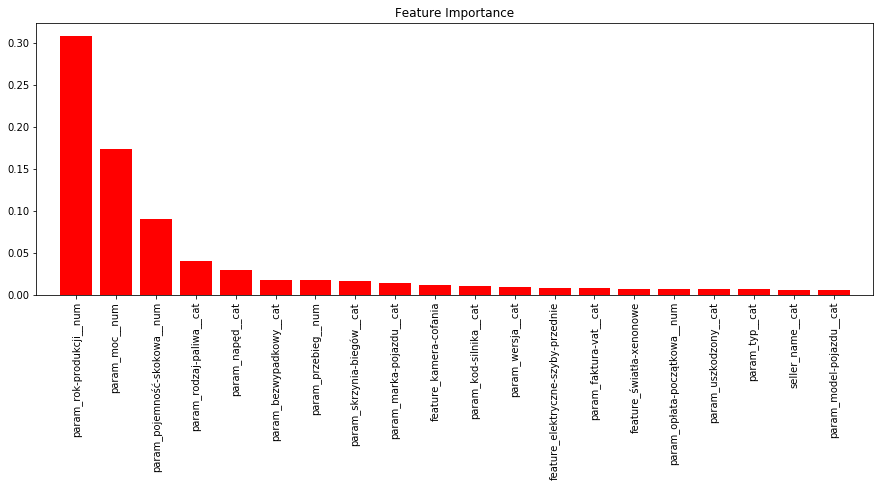

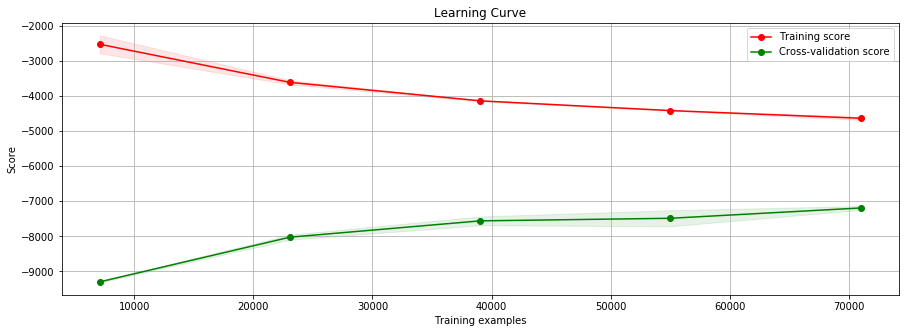

In [52]:
plot_fi_lc_e5(model, feats, True, True, False)

In [53]:
# Since XBG looks most promising it gets hyper optimized

X = df[feats].values
y = df['price_value_PLN'].values

def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'seed':0
    }

    print('training wiht params: {}'.format(xgb_params))
    model = xgb.XGBRegressor(**xgb_params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))

    print(scores)
    print('final_score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

training wiht params: {'max_depth': 17, 'learning_rate': 0.2292486606498665, 'colsample_bytree': 0.9045291540805207, 'subsample': 0.8005605675861506, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6977.23015655 -7155.95064072 -7101.27381755]        
final_score: 7078.151538273028                        

training wiht params: {'max_depth': 15, 'learning_rate': 0.058151084126340444, 'colsample_bytree': 0.9446681573422268, 'subsample': 0.8214679913911715, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6548.62394319 -6670.12514779 -6606.31807298]                                 
final_score: 6608.355721321551                                                 

training wiht params: {'max_depth': 16, 'learning_rate': 0.1381900022164647, 'colsample_bytree': 0.8217706723881326, 'subsample': 0.7456913284865578, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6717.33453

In [57]:
# checking hyperopt parameters

xgb_params_opt = {'colsample_bytree': 0.8788921383871157,
                  'learning_rate': 0.10169026353664928,
                  'max_depth': 13,
                  'min_child_weight': 1,
                  'subsample': 0.8444300922311613,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = xgb.XGBRegressor(**xgb_params_opt)

In [59]:
test_model(model, feats)

(6533.53927452918, 33.178818380728394)

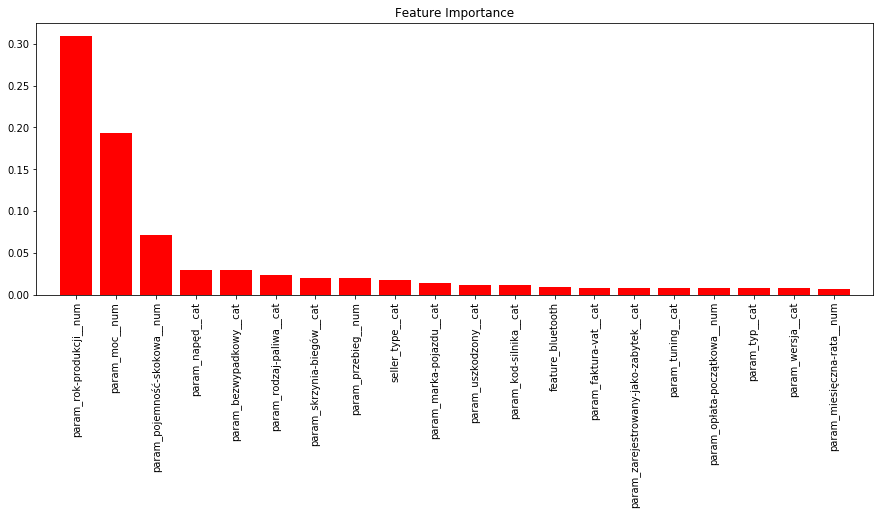

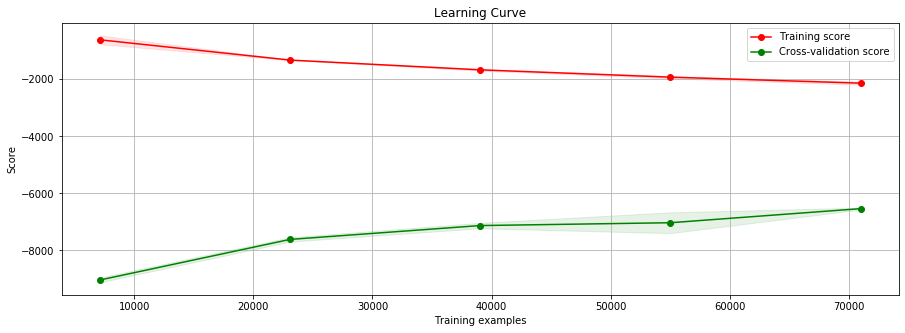

In [60]:
plot_fi_lc_e5(model, feats, True, True, False)

Model seems to be a bit over fitted so parameters were changed to:

In [70]:
xgb_params_opt = {'colsample_bytree': 0.8,
                  'learning_rate': 0.1,
                  'max_depth': 10,
                  'min_child_weight': 1,
                  'subsample': 0.8,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = xgb.XGBRegressor(**xgb_params_opt)
test_model(model, feats)

(6698.282876402001, 60.778434309329086)

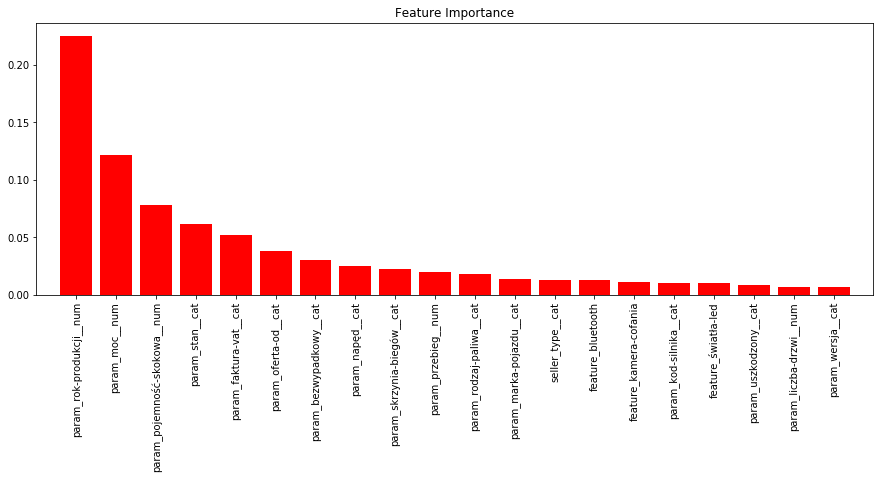

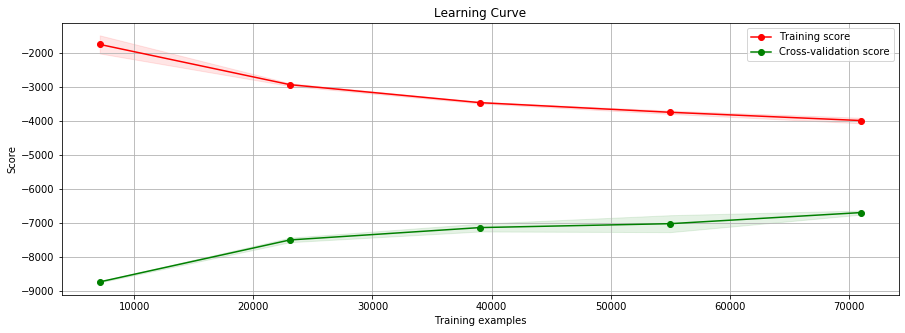

In [71]:
plot_fi_lc_e5(model, feats, True, True, False)

In [130]:
X, y = get_X_y(feats)

y_pred = cross_val_predict(model, X, y, cv=3)
df['pred'] = y_pred
df['error'] = df[['pred', 'price_value_PLN']].apply(lambda x: np.abs(x['pred'] - x['price_value_PLN']), axis=1)

In [145]:
less_feats + ['error']

['param_rok-produkcji__num',
 'param_moc__num',
 'param_rodzaj-paliwa__cat',
 'param_przebieg__num',
 'param_marka-pojazdu__cat',
 'param_napęd__cat',
 'param_skrzynia-biegów__cat',
 'param_liczba-drzwi__num',
 'param_pojemność-skokowa__num',
 'error']

In [147]:
df[less_feats + ['error']].sort_values('error', ascending=False)

,param_rok-produkcji__num,param_moc__num,param_rodzaj-paliwa__cat,param_przebieg__num,param_marka-pojazdu__cat,param_napęd__cat,param_skrzynia-biegów__cat,param_liczba-drzwi__num,param_pojemność-skokowa__num,error
147997,2015,605,2,3514,64,0,1,-1,4497,1.457933e+06
70100,2016,573,2,10,37,3,1,2,6000,1.015548e+06
33197,2016,570,2,3629,76,0,1,2,3799,8.476668e+05
126763,2006,-1,1,670000,18,0,0,2,-1,7.456470e+05
74514,1957,105,2,100,18,3,0,2,1897,6.681055e+05
...,...,...,...,...,...,...,...,...,...,...
51249,2010,80,2,110800,15,1,0,5,1198,1.230469e-01
36088,2009,130,1,208685,6,1,0,5,1870,8.203125e-02
17762,2005,163,1,329000,8,5,1,5,2400,4.492188e-02
23769,2006,140,1,217367,4,0,0,5,2000,3.906250e-02


In [139]:
df.groupby('param_rodzaj-paliwa')['error'].agg(np.max).reset_index().sort_values('error', ascending=False)

,param_rodzaj-paliwa,error
1,Benzyna,1.457933e+06
4,Diesel,7.456470e+05
0,-1,3.510329e+05
7,Hybryda,2.741022e+05
3,Benzyna+LPG,1.510778e+05
5,Elektryczny,1.217470e+05
2,Benzyna+CNG,1.546144e+04
6,Etanol,1.238055e+03


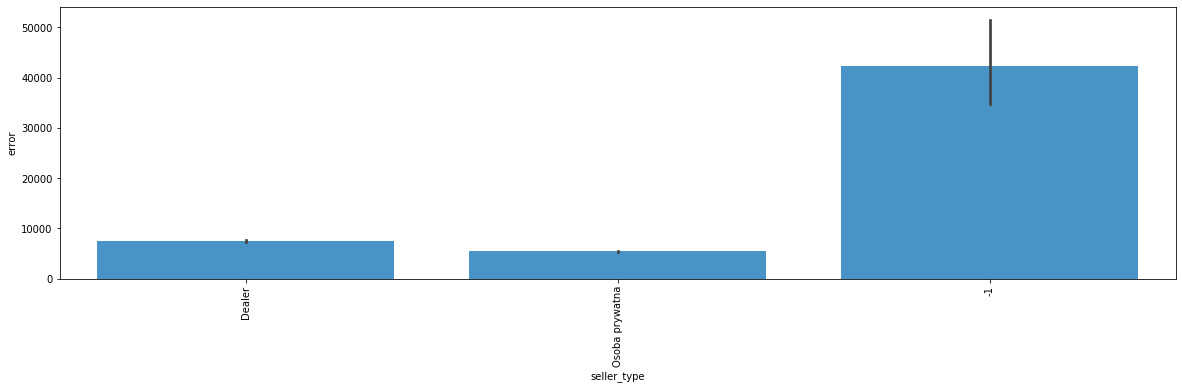

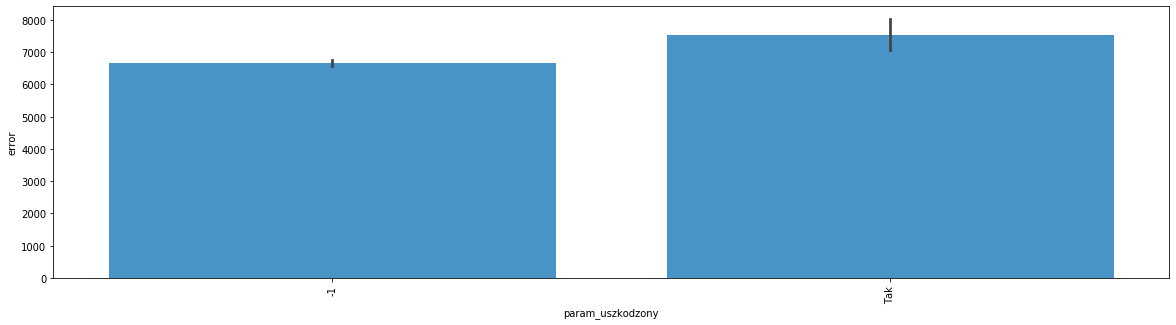

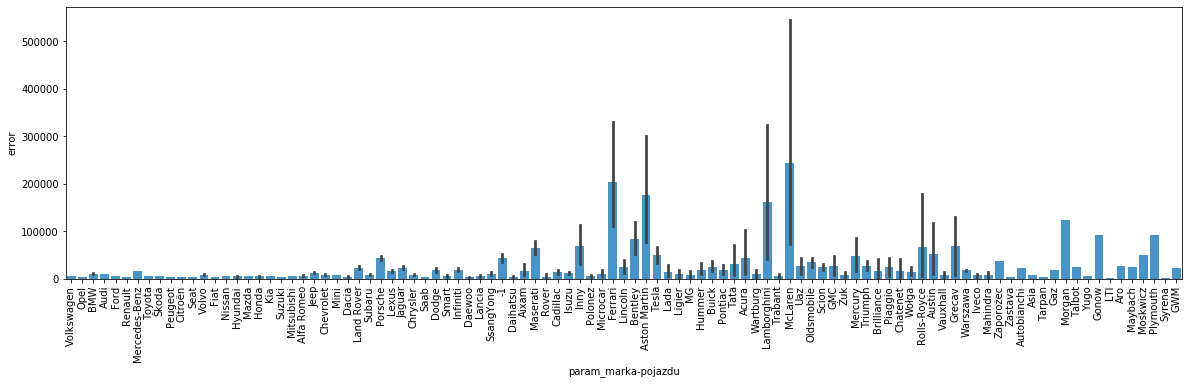

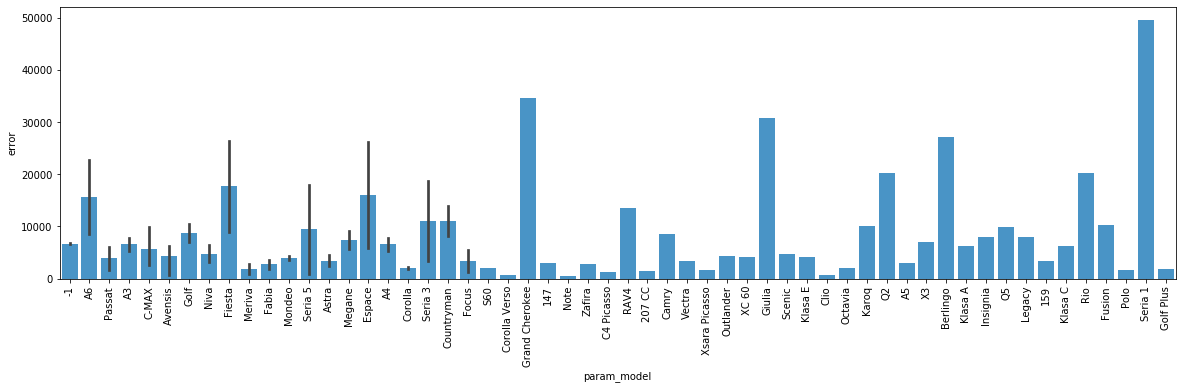

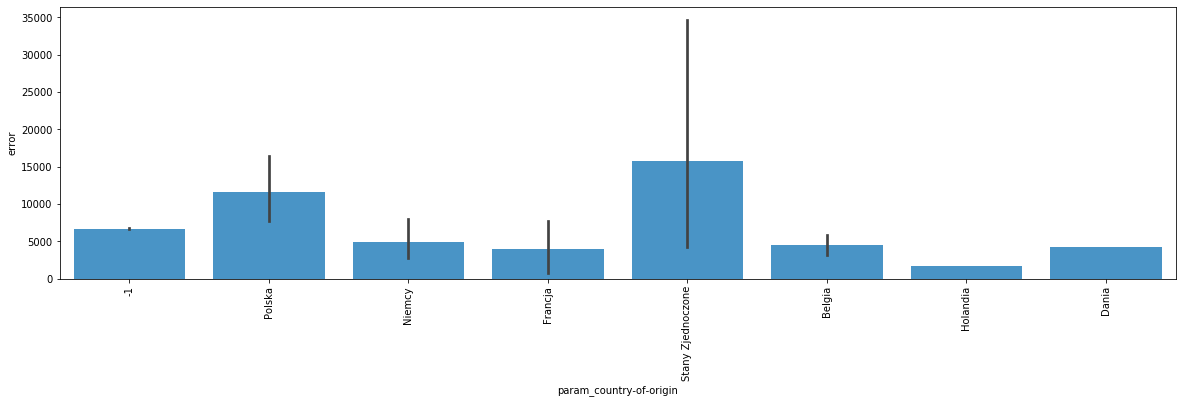

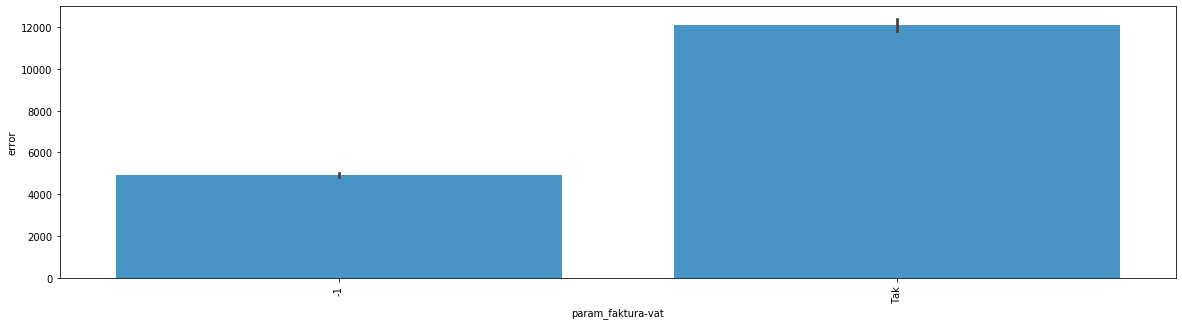

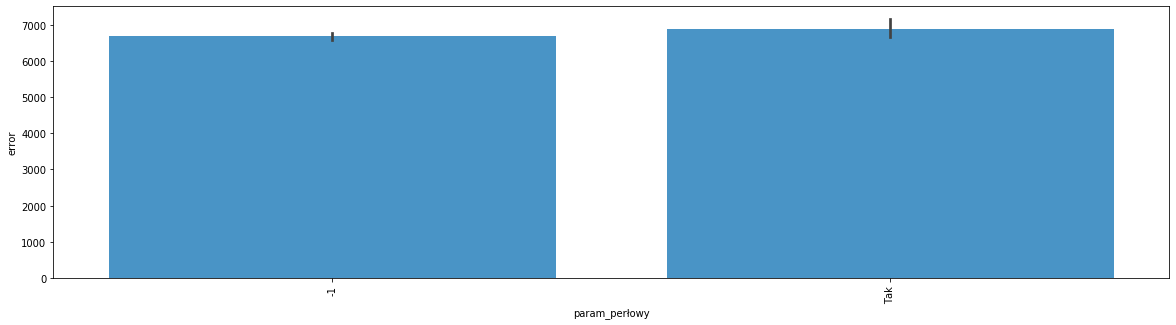

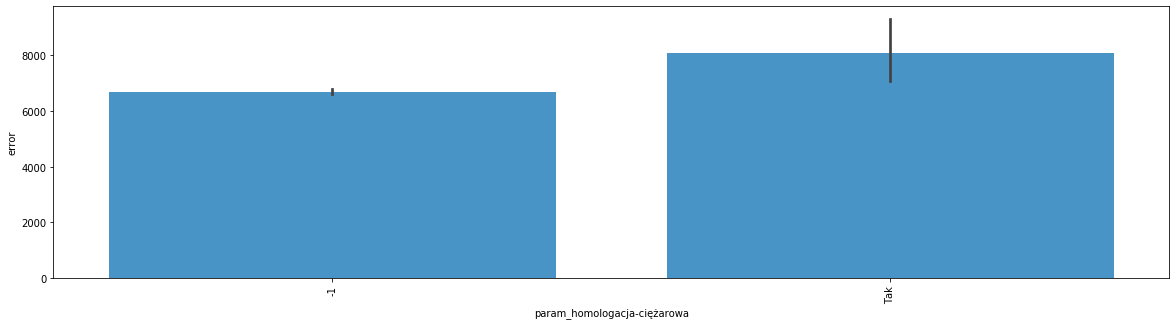

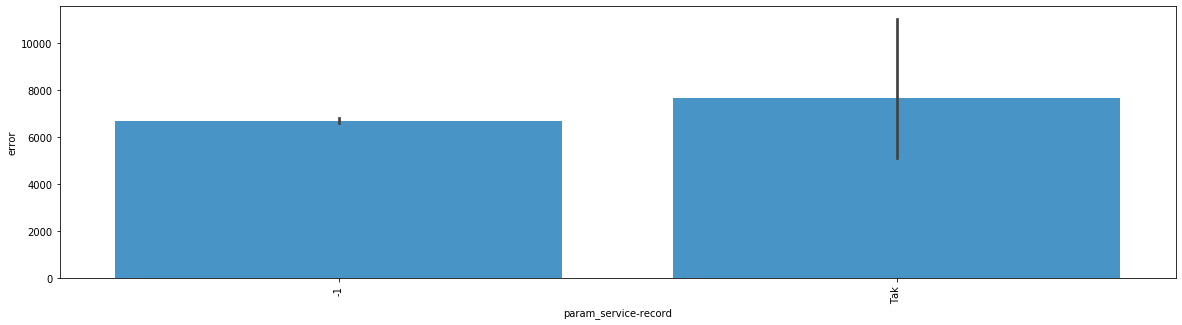

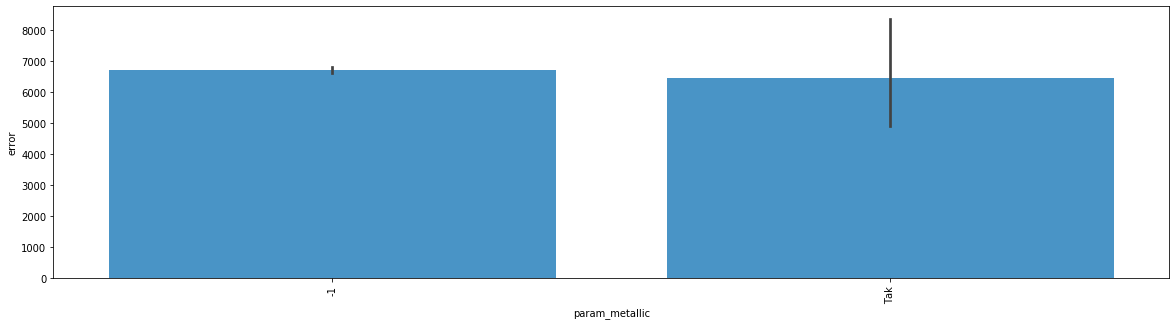

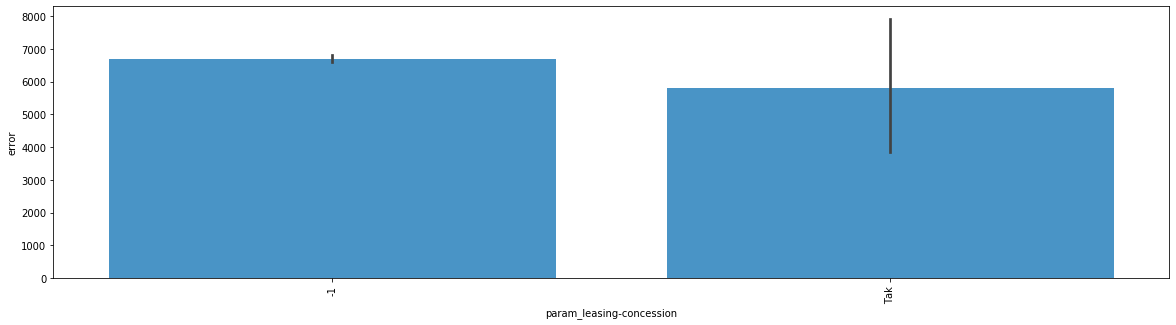

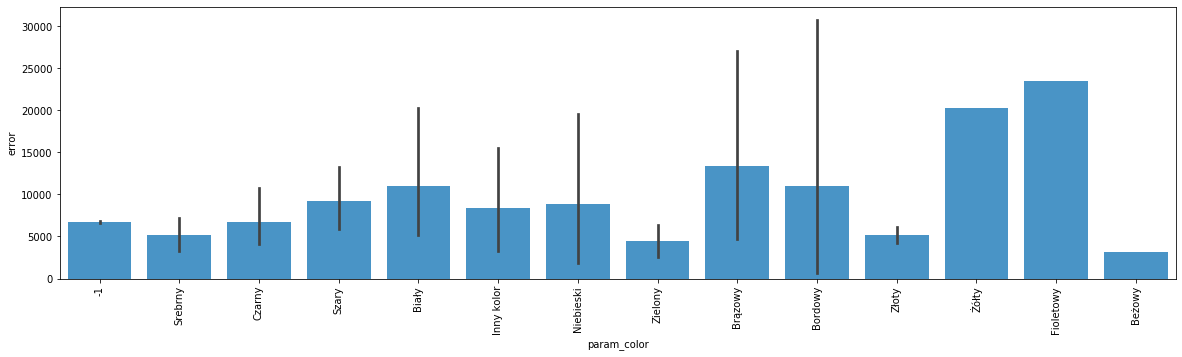

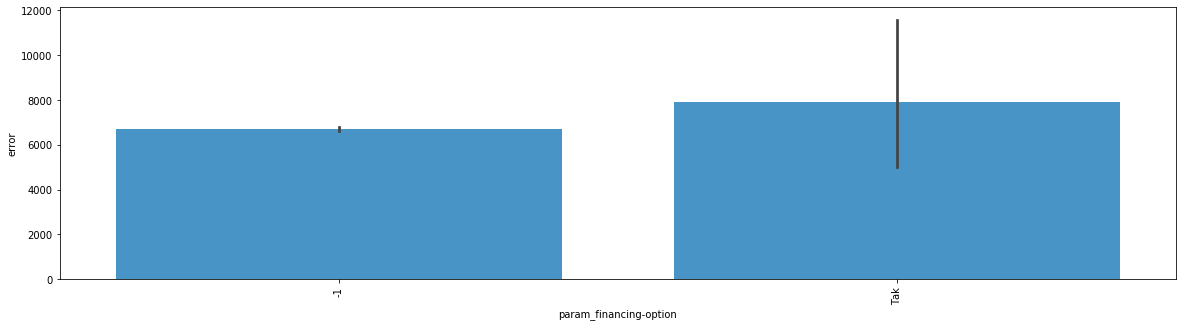

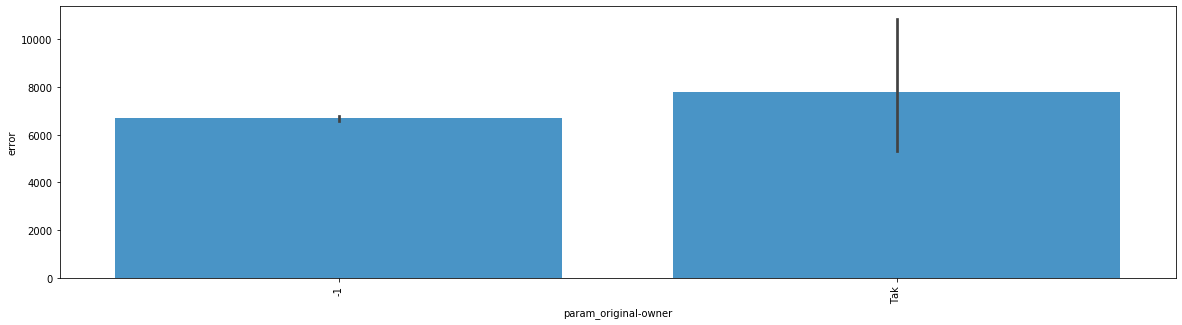

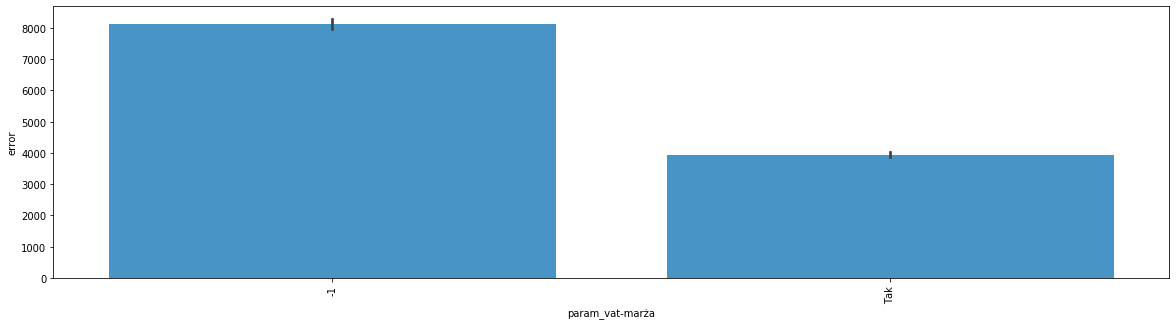

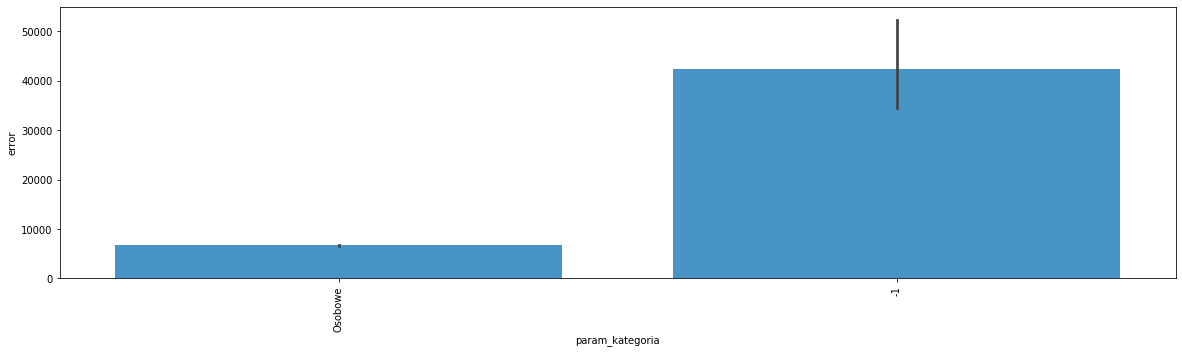

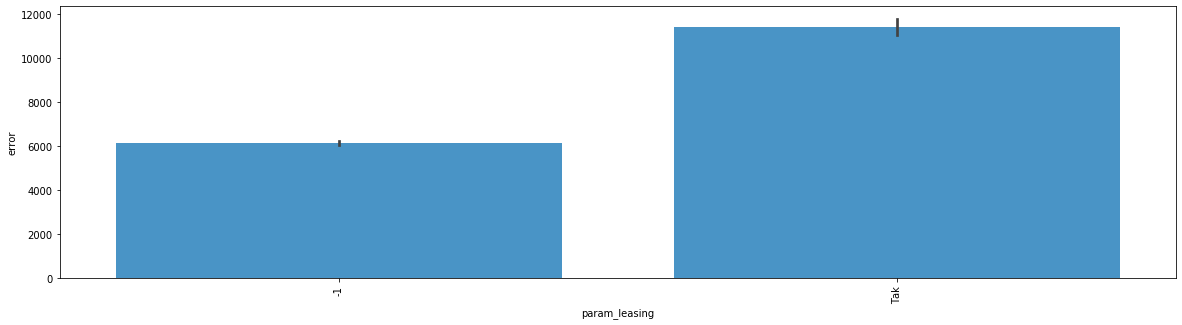

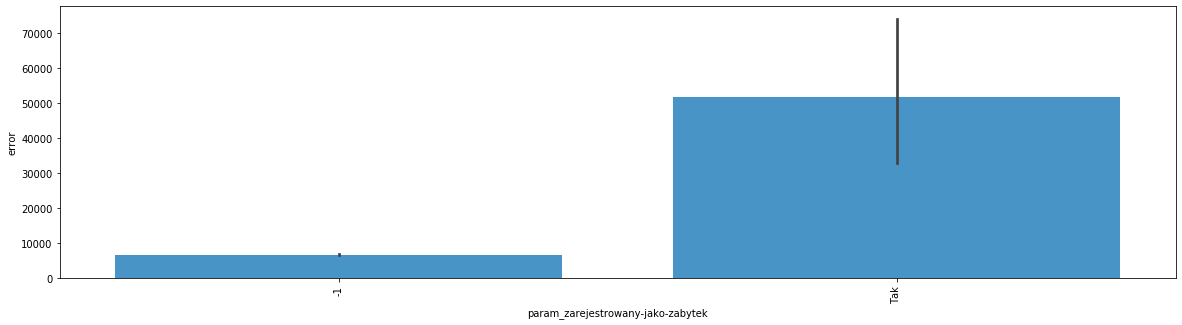

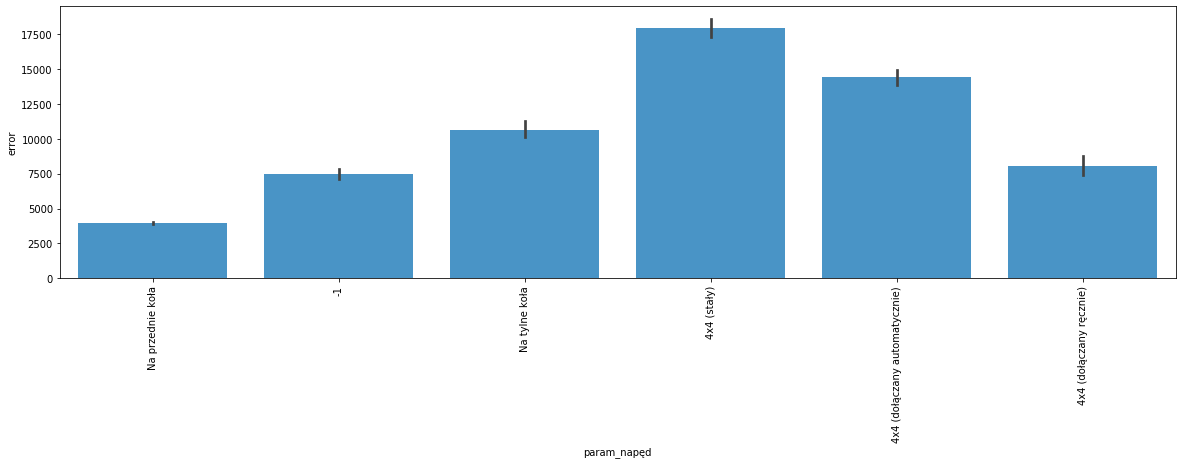

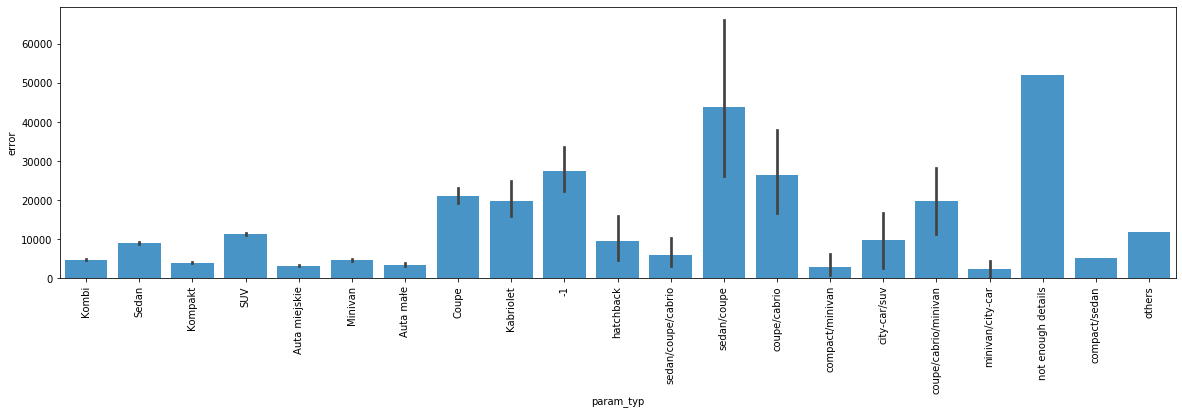

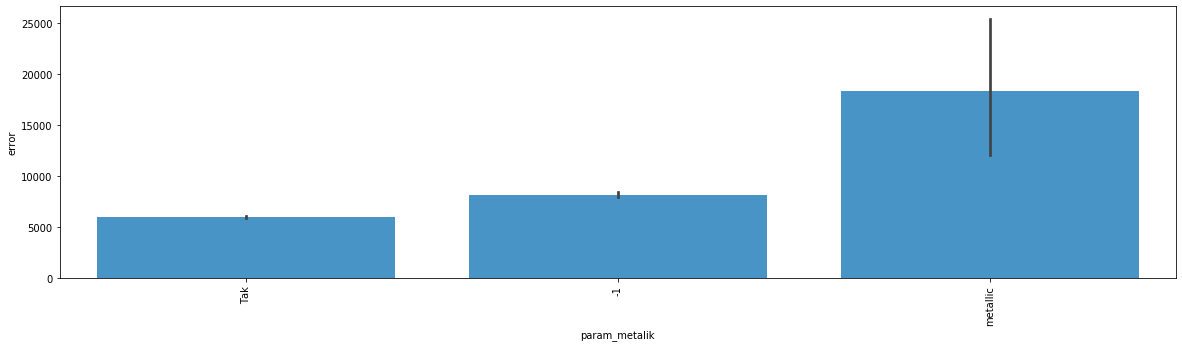

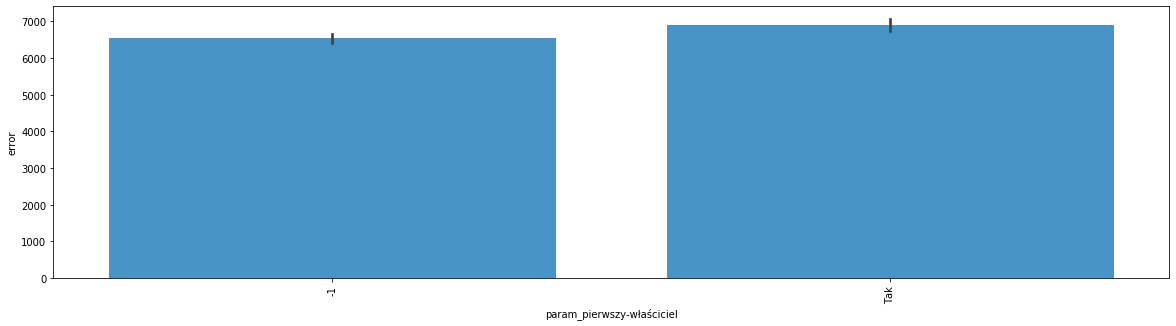

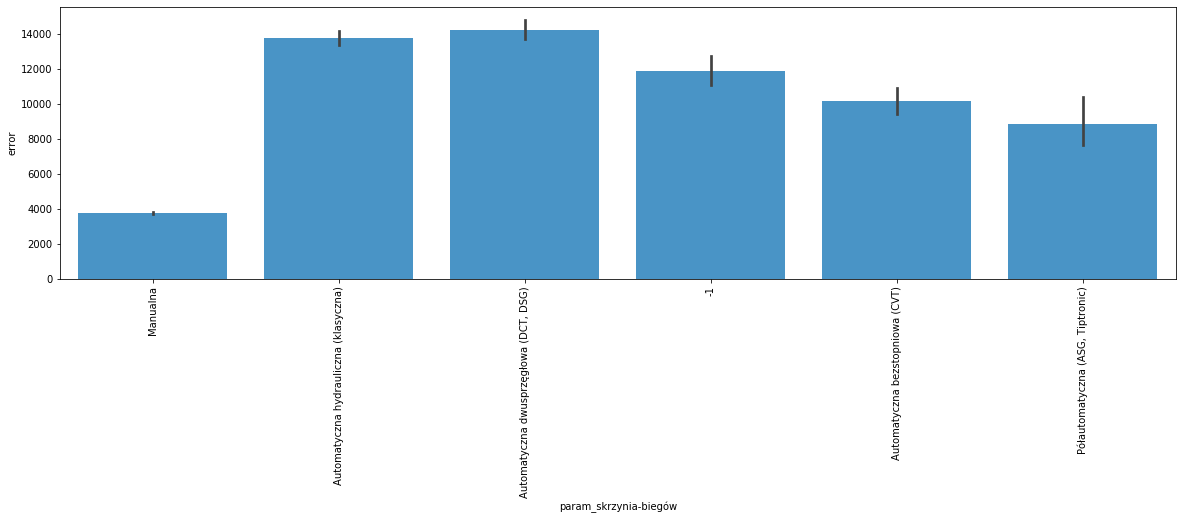

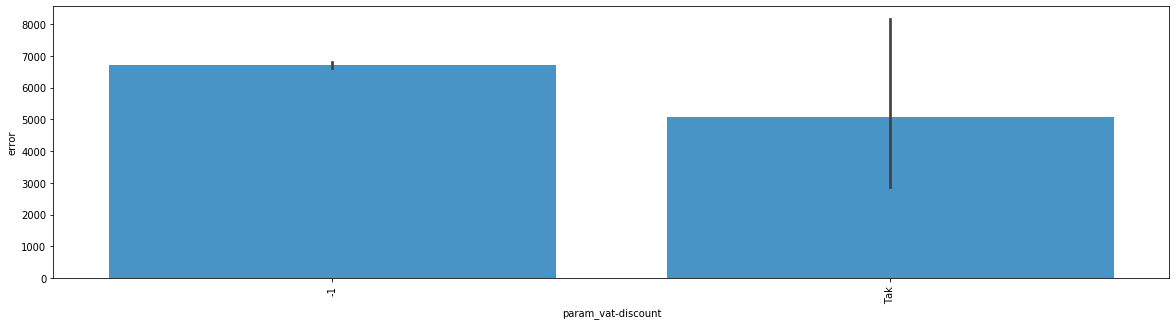

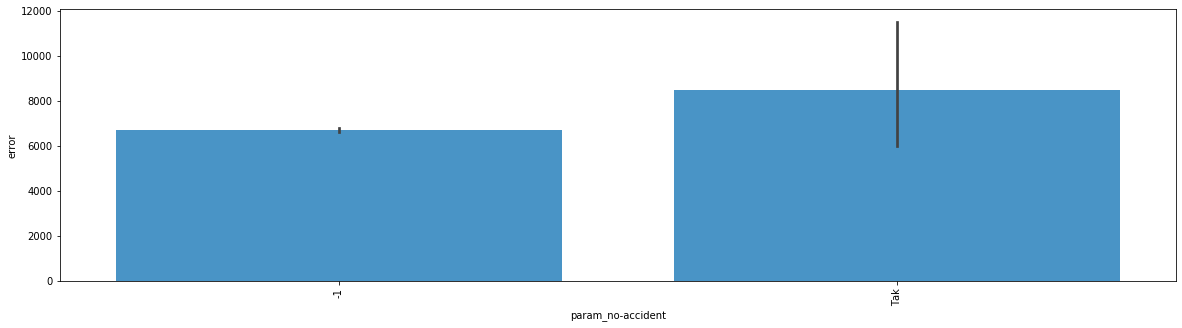

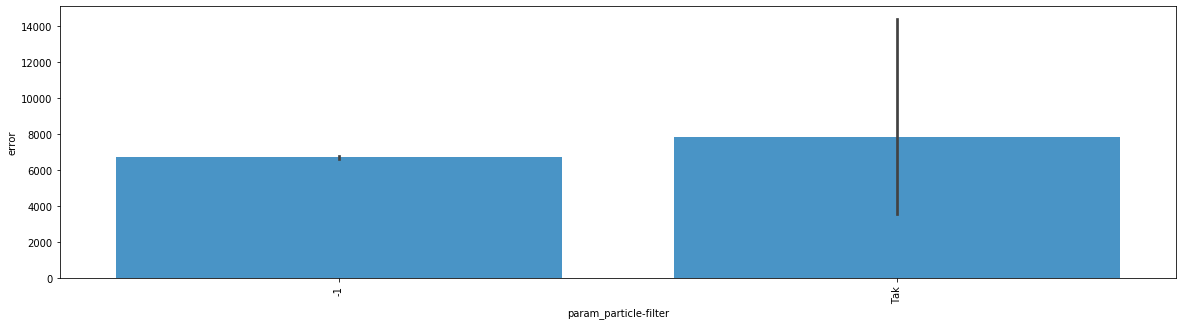

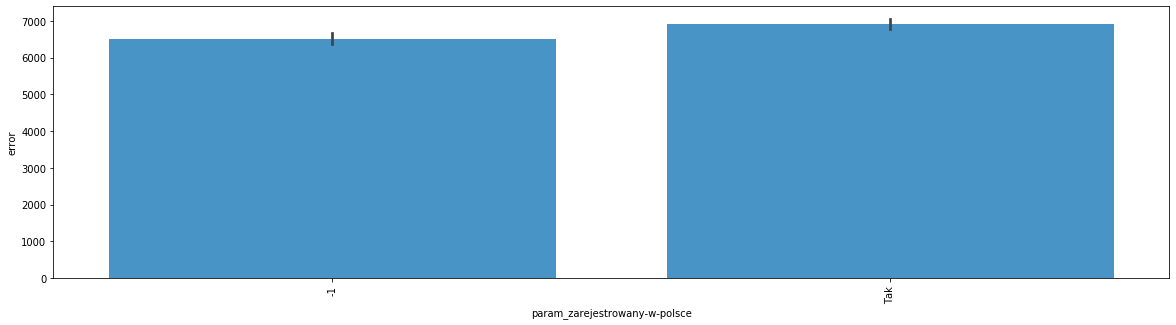

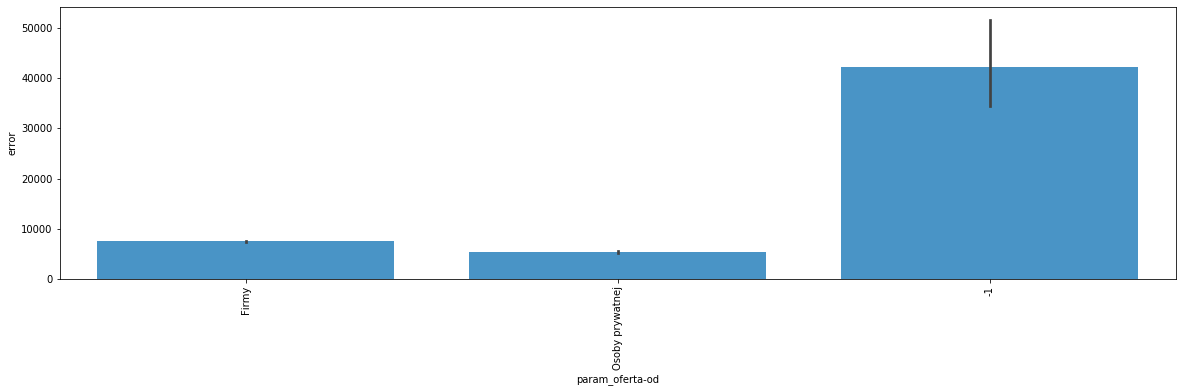

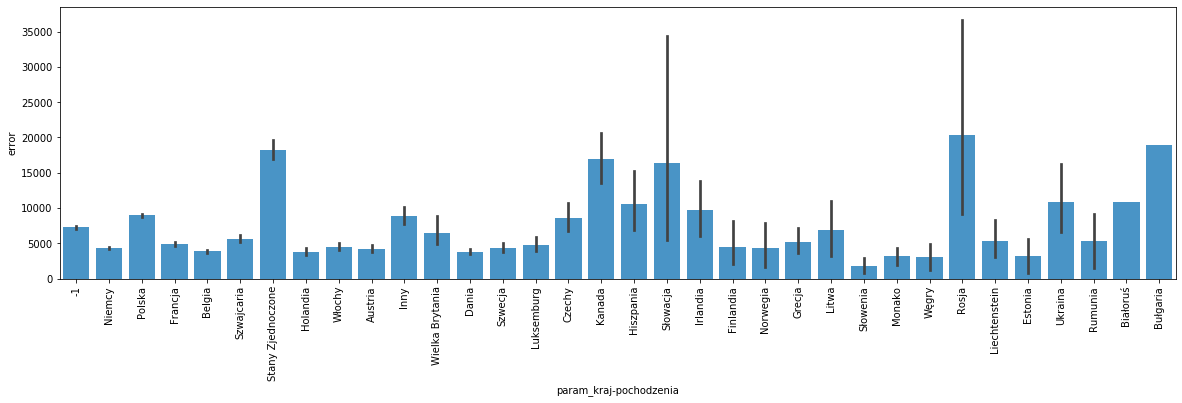

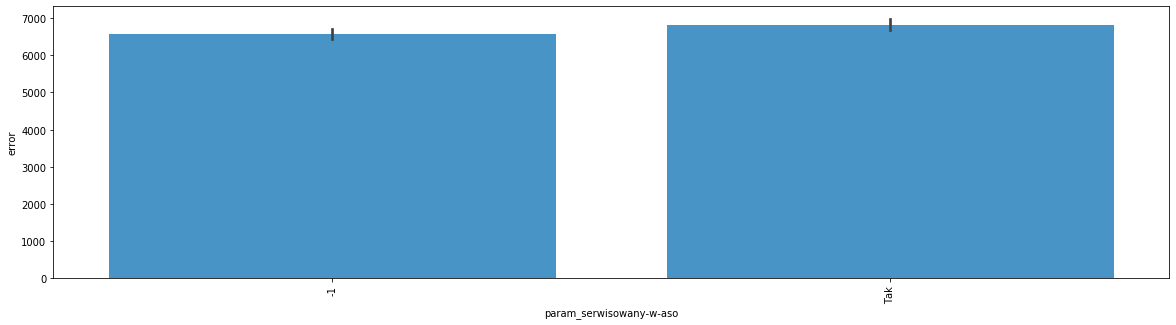

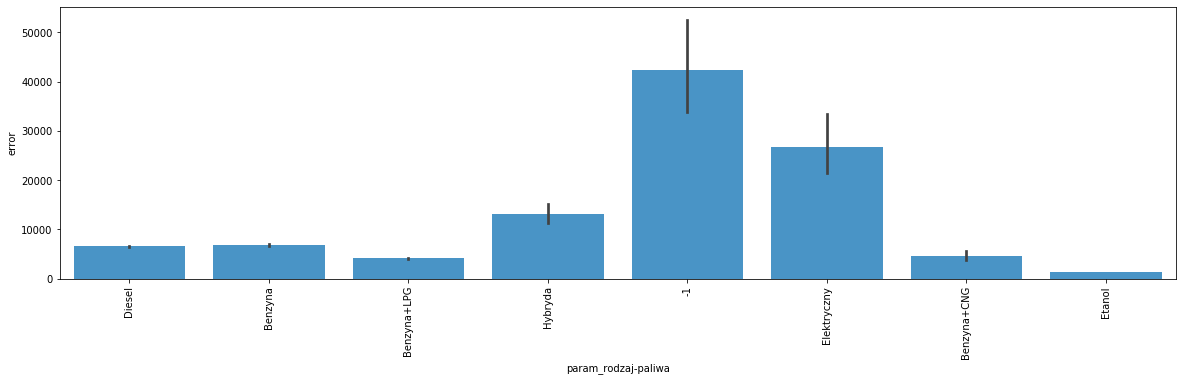

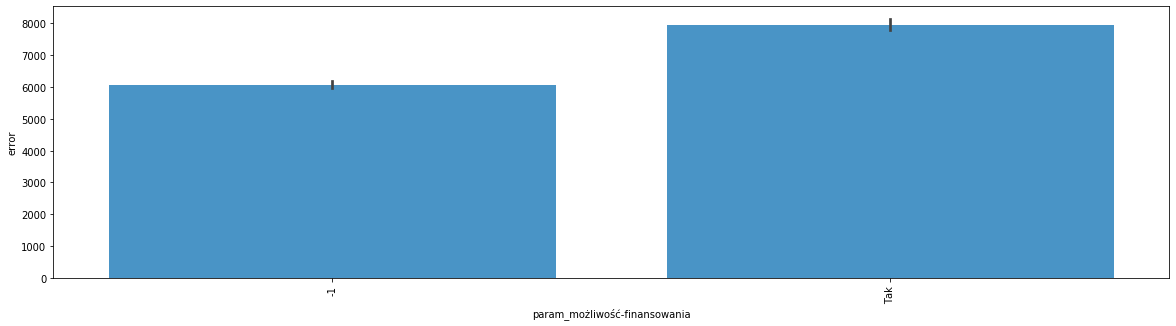

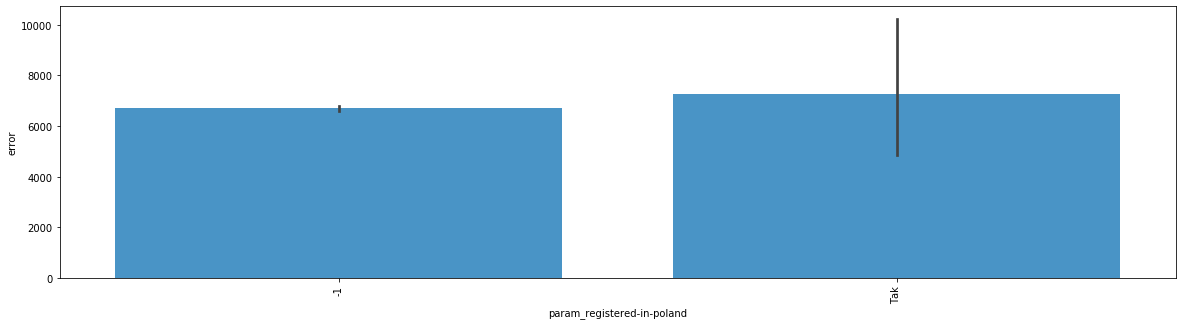

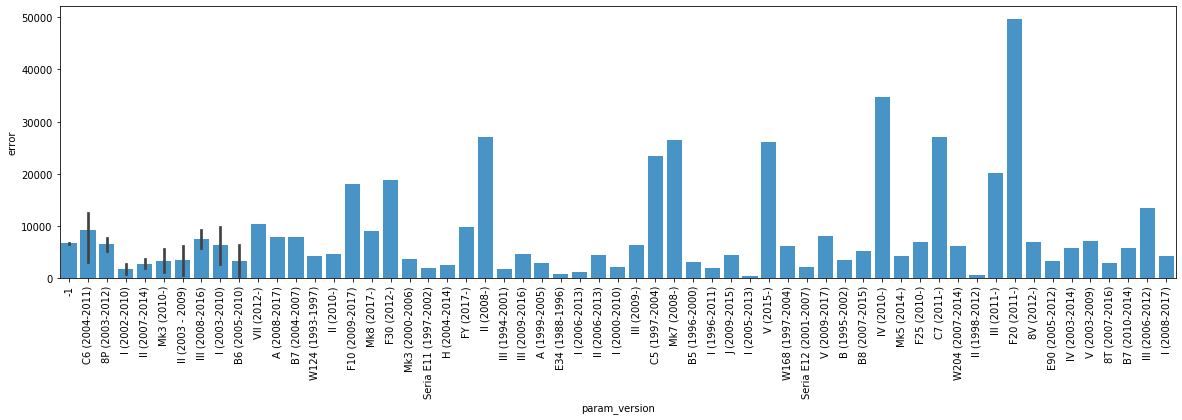

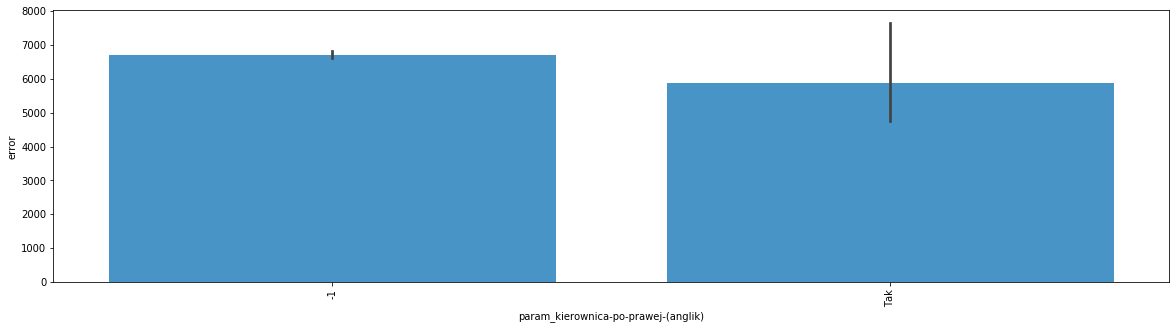

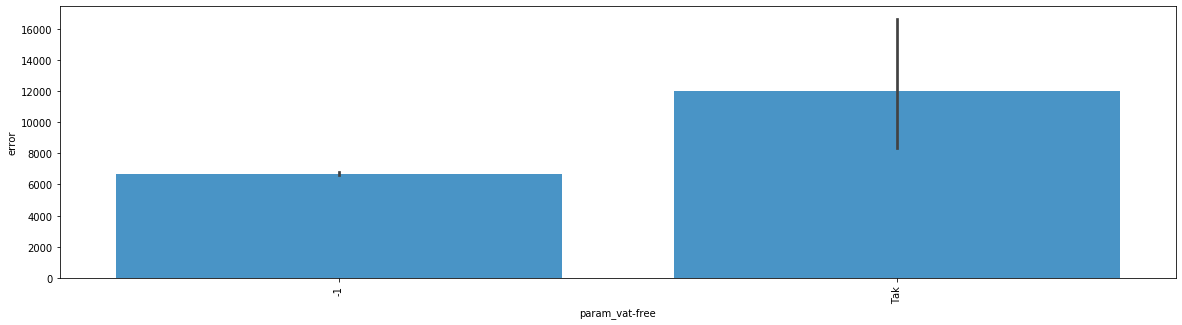

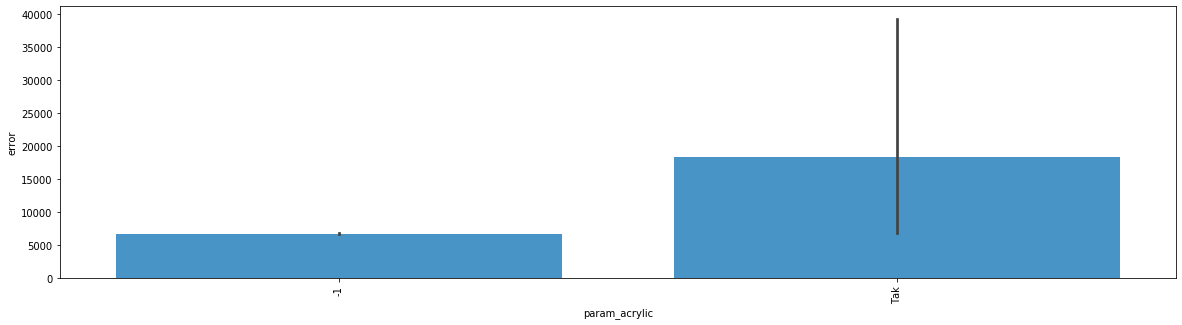

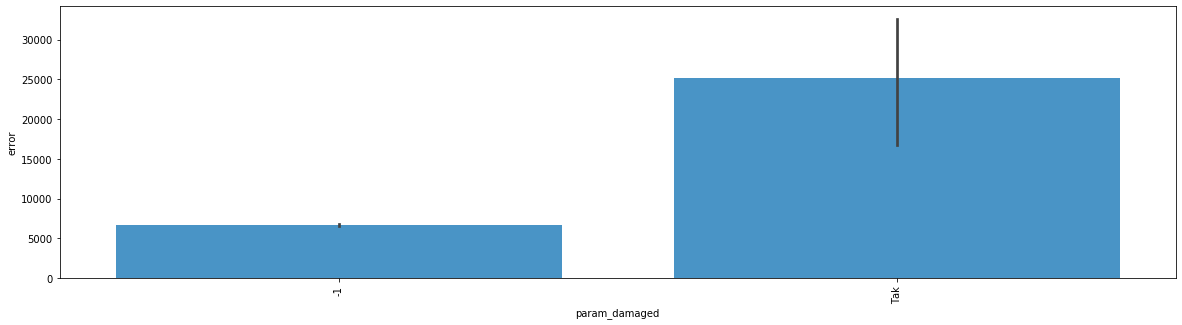

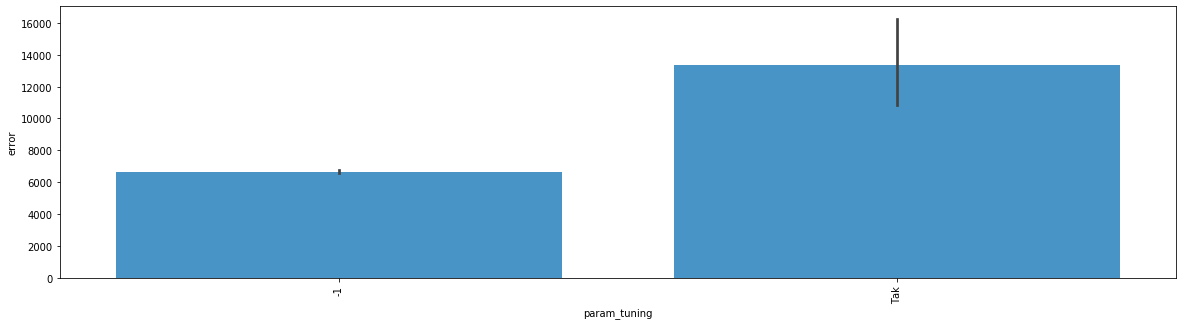

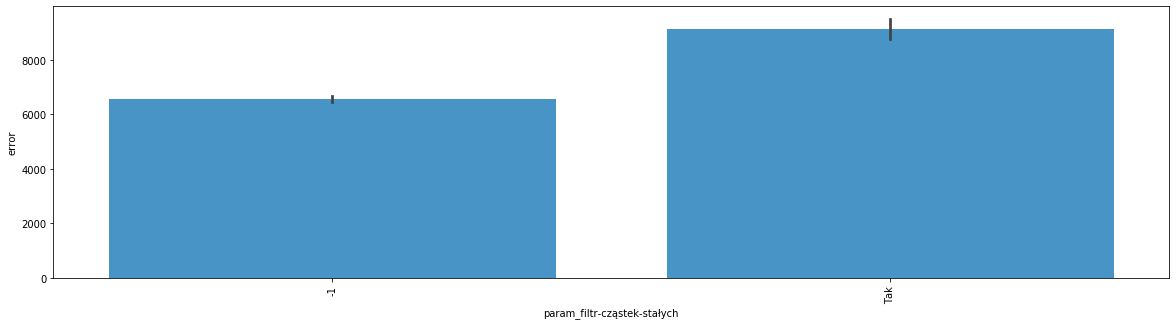

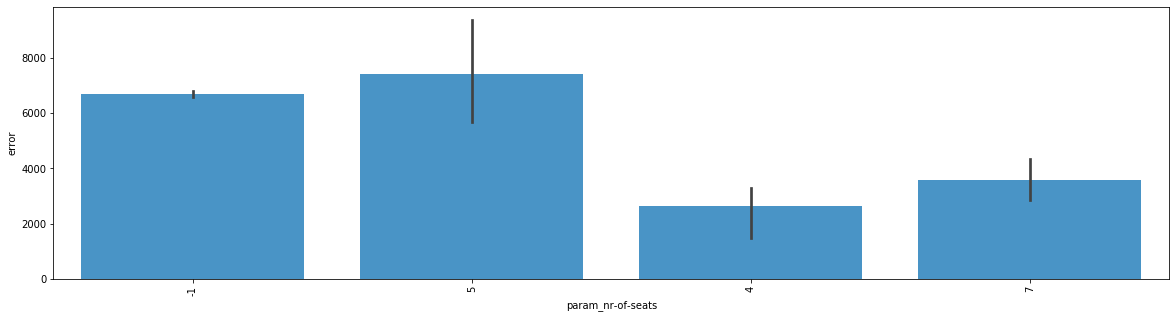

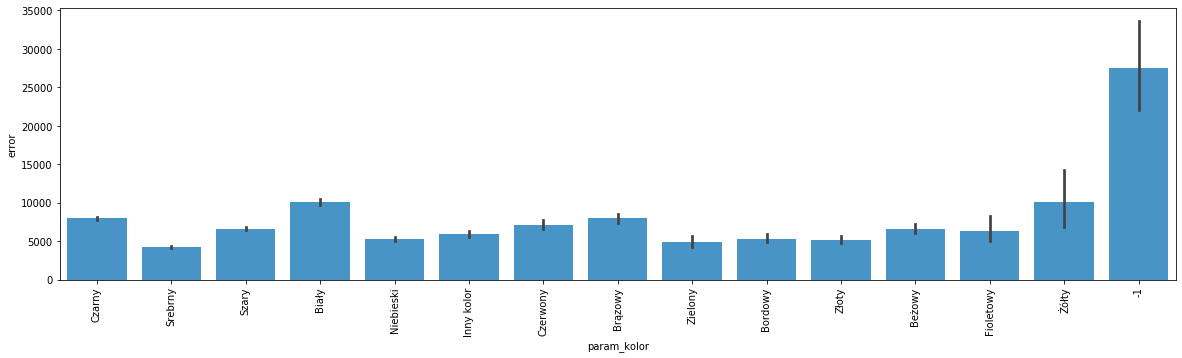

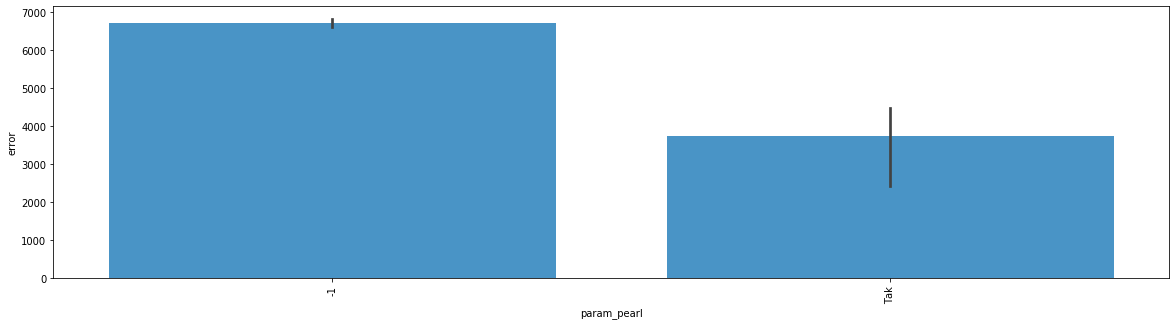

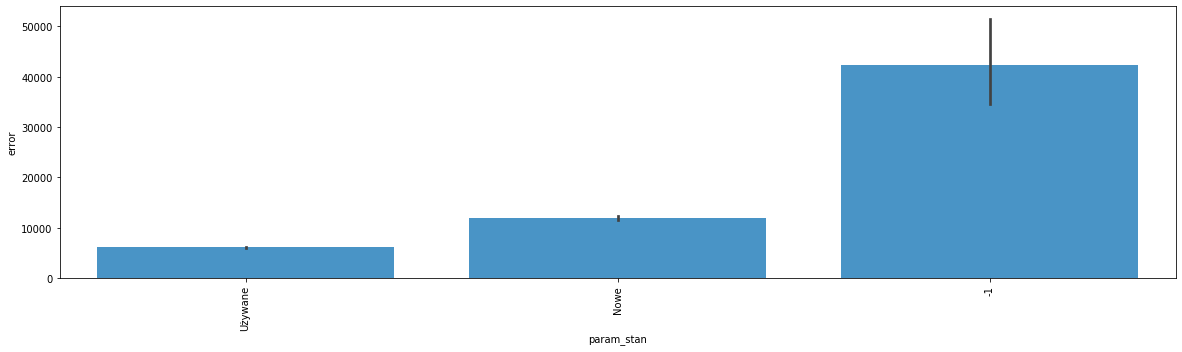

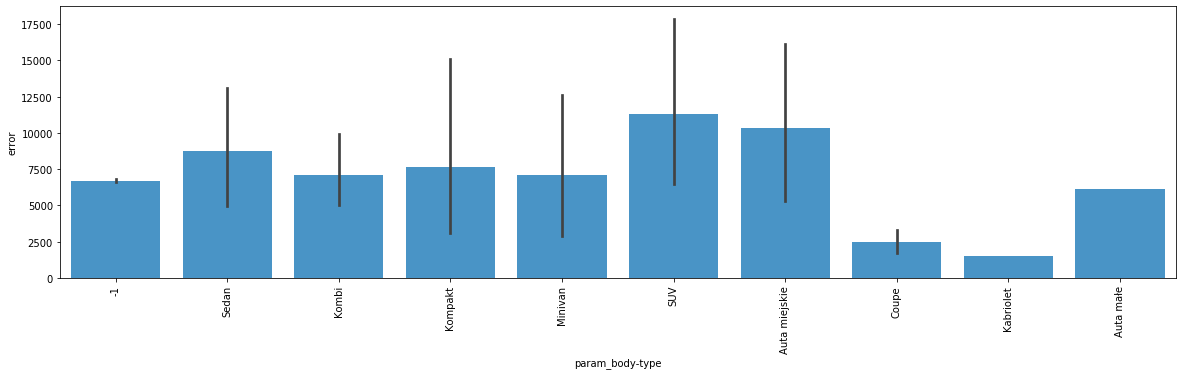

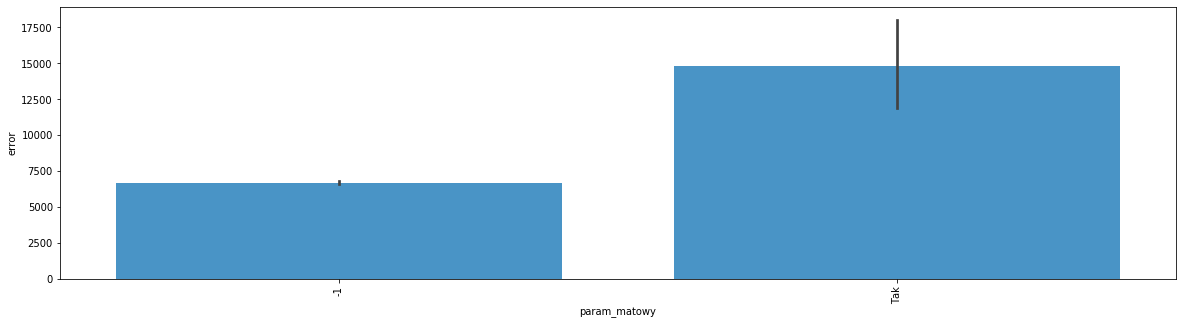

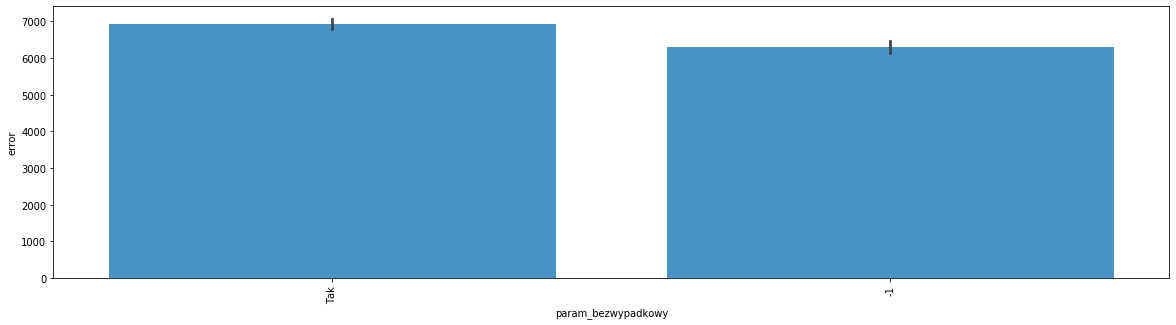

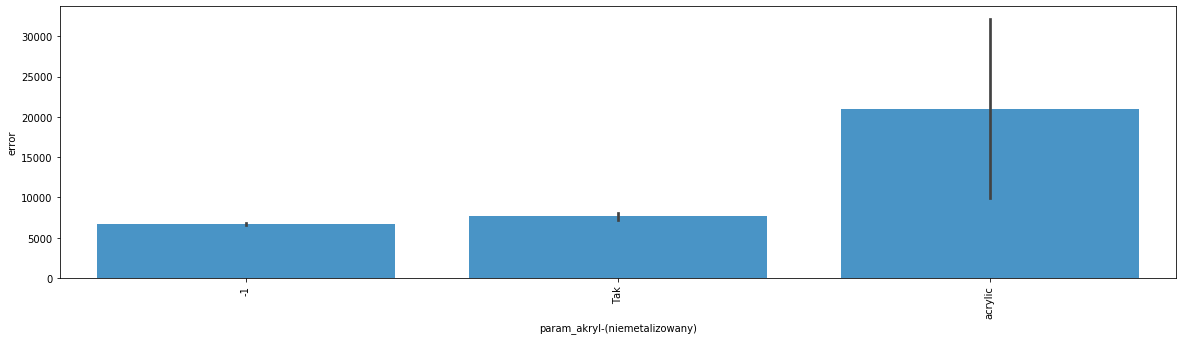

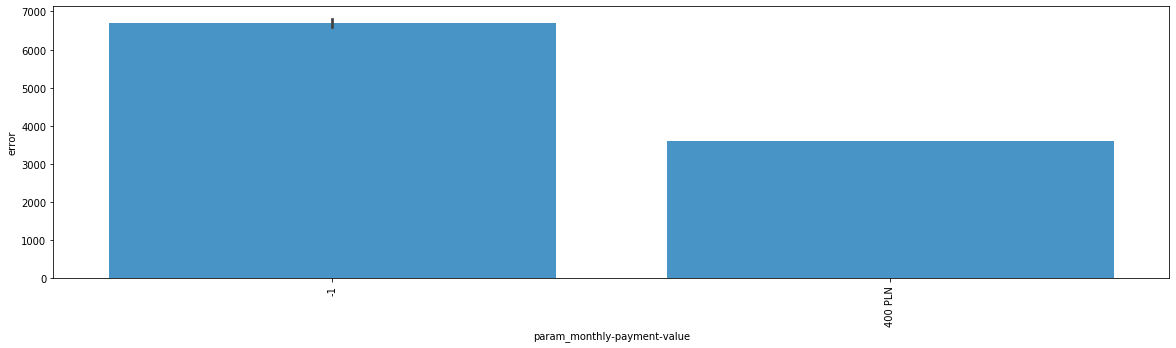

In [148]:
for cat_feat in cat_feats:
    if cat_feat not in cat_no_plot:
        cat_name = cat_feat[:-len(cat_feat_prefix)]
        plt.figure(figsize=(20,5))
        order = df.groupby(cat_name)['error'].agg(np.mean).reset_index().sort_values('error', ascending=False)[cat_name]
        sns.barplot(x=cat_name, y='error', data=df, order=df[cat_name].value_counts().index, color='#3498db');
        plt.xticks(rotation=90);
        plt.show()

In [ ]:
feat_mea = {}
for feat in feats:
    